# Detecting Multimodal AUC distributions in HNSCC 

We currently assign sensitivities by tail-assignment, however, there may be cases with distinctive multimodal distributions that are indicative of different response models. 

We'll begin by testing the method on beatAML data where we have much greater number of observations, and therefore more well defined distributions. 

$$ p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} } $$

In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [110]:
import pandas as pd 
import numpy as np
from sklearn.mixture import GMM
import seaborn as sbn
from matplotlib import pyplot as plt
import warnings
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

warnings.filterwarnings("ignore")

In [44]:
aml_var_all = pd.read_csv('./../data/vizome_beatAML_variants.csv', skiprows=[0,1,2])
#[aml_var_all.tumor_only == True]
aml_var = aml_var_all.dropna()[['sample_id', 'gene', 'chr','start','end','ref','alt','variant','sift']]

aml_var = aml_var.rename(columns={'sample_id':'lab_id'})

print(aml_var.head())

print(aml_var[['chr','start','end','ref','alt']].head())

print('Number of genes mutated: %d' %len(aml_var.gene.unique()))
print('Number of unique mutations: %d' %aml_var[['chr','start','end','ref','alt']].drop_duplicates().shape[0])

mut_cnt = aml_var.groupby('gene').count()['lab_id'].sort_values()
#mult_patients = mut_cnt.index[mut_cnt > 1]
#aml_variants = aml_var[aml_var['lab_id'].isin(mult_patients)]

print(one_off_mutations)
print(aml_var.groupby('gene').count()['lab_id'].sort_values())

aml_var.head()

     lab_id      gene chr    start      end ref alt           variant  \
0  14-00141  C1orf170   1   914477   914477   C   T  missense_variant   
3  13-00515    UBE2J2   1  1192625  1192625   T   G  missense_variant   
5  14-00244    ATAD3B   1  1417649  1417649   T   G  missense_variant   
7  15-00900    ATAD3A   1  1463113  1463113   T   A  missense_variant   
8  15-00988    ATAD3A   1  1463113  1463113   T   A  missense_variant   

                sift  
0    tolerated(0.12)  
3  deleterious(0.05)  
5       tolerated(1)  
7     deleterious(0)  
8     deleterious(0)  
  chr    start      end ref alt
0   1   914477   914477   C   T
3   1  1192625  1192625   T   G
5   1  1417649  1417649   T   G
7   1  1463113  1463113   T   A
8   1  1463113  1463113   T   A
Number of genes mutated: 298
Number of unique mutations: 338
Index(['TRAV9-2', 'ZDHHC13', 'ZCCHC14', 'TRMT5', 'TRAPPC8', 'WNK1', 'WDR43',
       'TRDN', 'TRIM64C', 'STT3A', 'ABCE1', 'ORC2', 'ERG', 'STAG2', 'JAK3',
       'KIAA1328'

lab_id      gene chr    start      end ref alt           variant  \
0  14-00141  C1orf170   1   914477   914477   C   T  missense_variant   
3  13-00515    UBE2J2   1  1192625  1192625   T   G  missense_variant   
5  14-00244    ATAD3B   1  1417649  1417649   T   G  missense_variant   
7  15-00900    ATAD3A   1  1463113  1463113   T   A  missense_variant   
8  15-00988    ATAD3A   1  1463113  1463113   T   A  missense_variant   

                sift  
0    tolerated(0.12)  
3  deleterious(0.05)  
5       tolerated(1)  
7     deleterious(0)  
8     deleterious(0)

In [60]:
[3] + [4,5,6]

[3, 4, 5, 6]

In [71]:
# convert variants to matrix format 

genes = pd.Series( aml_var.gene.unique() )

res = []
for lab_id in aml_var.lab_id.unique(): 
    D = aml_var[aml_var['lab_id'] == lab_id]
    x = genes.isin( D['gene'] ).tolist()
    res.append( [lab_id] + [str(int(xx)) for xx in x] )

res = pd.DataFrame( res, columns=['lab_id'] + genes.tolist() )

res.head()

MAT_VAR = res 

print('matrix variant shape: %s' %str(res.shape))
print(MAT_VAR.head())

matrix variant shape: (368, 299)
     lab_id C1orf170 UBE2J2 ATAD3B ATAD3A NADK AJAP1 FAM131C ARHGEF19 PADI2  \
0  14-00141        1      0      0      0    0     0       0        0     0   
1  13-00515        0      1      0      0    0     0       0        0     0   
2  14-00244        0      0      1      0    0     0       0        0     0   
3  15-00900        0      0      0      1    0     0       0        0     0   
4  15-00988        0      0      0      1    0     0       0        0     0   

   ... GDPD2 ZNF711 CT47B1 STAG2 MST4 SAGE1 GPR112 GABRQ ZNF185 CTAG2  
0  ...     0      0      0     0    0     0      0     0      0     0  
1  ...     0      0      0     0    0     0      0     0      0     0  
2  ...     0      0      0     0    0     0      0     0      0     0  
3  ...     0      0      0     0    0     0      0     0      0     0  
4  ...     0      0      0     0    0     0      0     0      0     0  

[5 rows x 299 columns]


In [38]:
aml_aucs = pd.read_csv('./../data/beatAML_aucs.csv')[['inhibitor','lab_id','auc']].drop_duplicates()

#aml_aucs = pd.read_csv('./../data/beatAML_AUCs_subset.csv')

In [39]:
aml_aucs.head()

inhibitor    lab_id         auc
0   17-AAG (Tanespimycin)  12-00211  225.918025
7   17-AAG (Tanespimycin)  12-00219  135.264409
14  17-AAG (Tanespimycin)  12-00258  164.561227
21  17-AAG (Tanespimycin)  12-00262  111.555971
28  17-AAG (Tanespimycin)  12-00268  226.805281

In [78]:
print( aml_aucs.head() )

aml_aucs['lab_id']=aml_aucs['lab_id'].astype(str)
MAT_VAR['lab_id']=MAT_VAR['lab_id'].astype(str)

aml_auc_w_var = aml_aucs.merge(right=MAT_VAR, how='inner', on=['lab_id'])
aml_auc_w_var.head(5)

                inhibitor    lab_id         auc
0   17-AAG (Tanespimycin)  12-00211  225.918025
7   17-AAG (Tanespimycin)  12-00219  135.264409
14  17-AAG (Tanespimycin)  12-00258  164.561227
21  17-AAG (Tanespimycin)  12-00262  111.555971
28  17-AAG (Tanespimycin)  12-00268  226.805281


inhibitor    lab_id         auc C1orf170 UBE2J2 ATAD3B ATAD3A  \
0  17-AAG (Tanespimycin)  13-00098  230.223782        0      0      0      0   
1               A-674563  13-00098  238.292837        0      0      0      0   
2                ABT-737  13-00098  250.618488        0      0      0      0   
3   Afatinib (BIBW-2992)  13-00098  212.156124        0      0      0      0   
4       AKT Inhibitor IV  13-00098  176.353301        0      0      0      0   
5    Alisertib (MLN8237)  13-00098  235.615877        0      0      0      0   
6         AMPK Inhibitor  13-00098  219.546866        0      0      0      0   
7                 AT7519  13-00098  172.886723        0      0      0      0   
8   Axitinib (AG-013736)  13-00098  233.581812        0      0      0      0   
9                AZD1480  13-00098  245.186758        0      0      0      0   

  NADK AJAP1 FAM131C  ... GDPD2 ZNF711 CT47B1 STAG2 MST4 SAGE1 GPR112 GABRQ  \
0    0     0       0  ...     0      0      0     0    0     0      0     0   
1    0     0       0  ...     0      0      0     0    0     0      0     0   
2    0     0       0  ...     0      0      0     0    0     0      0     0   
3    0     0       0  ...     0      0      0     0    0     0      0     0   
4    0     0       0  ...     0      0      0     0    0     0      0     0   
5    0     0       0  ...     0      0      0     0    0     0      0     0   
6    0     0       0  ...     0      0      0     0    0     0      0     0   
7    0     0       0  ...     0      0      0     0    0     0      0     0   
8    0     0       0  ...     0      0      0     0    0     0      0     0   
9    0     0       0  ...     0      0      0     0    0     0      0     0   

  ZNF185 CTAG2  
0      0     0  
1      0     0  
2      0     0  
3      0     0  
4      0     0  
5      0     0  
6      0     0  
7      0     0  
8      0     0  
9      0     0  

[10 rows x 301 columns]

In [93]:
def add_normal_plot(mu, s, weight, c, ax, auc_max=300): 
    '''
    mu = mean
    s = standard deviation
    ax = matplotlib axes to add to 
    c = color {[r b g c y ...]} <str> 
    '''
    
    x = np.arange(0, auc_max, 1)
    y = (1/(2*np.pi*s**2)**(0.5))*np.exp( - (x-mu)**2/(2*s**2) ) * weight
    
    ax = ax.plot(x,y, color=c, label='mean: %.1f, std: %.1f' %(mu, s))

def get_color():
    '''
    
    '''
    for c in ['r','b','g','c','y']: 
        yield c
    

In [23]:
gen = get_color()
gen.__next__()

'r'

In [96]:
def test_multimodal_fits(X, ntests=10, kmax=5, plot=True, inhib=None): 
    '''
    
    '''
    
    res = {x:[] for x in ['k', 'aic', 'bic']}
    for k in range(1,kmax): 
        for i in range(ntests): 
            
            #print('k: %d' %k)
            gmm = GMM(n_components=k, n_init=1)
            gmm.fit(X)
            res['k'].append( k )
            res['aic'].append( gmm.aic(X) )
            res['bic'].append( gmm.bic(X) )
            
    res = pd.DataFrame( res )
    
    best_k = res[res.bic == np.min(res.bic)].k.unique()[0]
    gmm_best = GMM(n_components=best_k,n_init=20) 
    gmm_best.fit(X)
    P = gmm_best.predict(X)
    
    if plot:         
        nbins = 50
        bin_ = np.arange(0,np.max(X),np.max(X)/nbins)
        
        scalar_to_make_pretty = 0.25 # since our fitted Gaussians are normalized to their weights, they appear smaller
        weights_ = scalar_to_make_pretty/len(X)
        
        f, axs = plt.subplots(1,3,figsize=(15,5)) 
        sbn.distplot(X, bins=bin_, ax=axs[0]).set_title('AUC distribution')
        sbn.scatterplot(x='k', y='bic', alpha=0.3, data=res, ax=axs[1]).set_title('BIC vs K')
        
        clas = 0
        for weight, mean, covars, c in zip(gmm_best.weights_, gmm_best.means_, gmm_best.covars_, get_color()): 
            sbn.distplot(X[P==clas], bins=bin_, kde=False, color=c, ax=axs[2], label='AUC', hist_kws={'weights': [weights_]*len(X[P==clas])})
            add_normal_plot(mean[0], (covars[0])**0.5, weight, c, axs[2], auc_max=np.max(X))
            clas+=1
        
        axs[2].set_title('Optimal GMM fit')
        
        plt.legend()
        plt.suptitle(inhib)
        
        print('Number of assays (aucs): %d' %len(X))
        print('Optimal K: %d [BIC=%.1f]' %(best_k, np.min(res.bic)))
        print('GMM fit:\n\tMixture Weights: %r\n\tMeans: %r\n\tVariances: %r' %(gmm_best.weights_.ravel(), gmm_best.means_.ravel(), gmm_best.covars_.ravel()))
        print('Class counts: %r' %['class %d: %d' %(cl, len(X[P==cl])) for cl in list(set(P))])
        
        plt.show()
        
    return P
            
            
    

Dasatinib auc and variants shape: (197, 301)
Number of assays (aucs): 197
Optimal K: 2 [BIC=2176.0]
GMM fit:
	Mixture Weights: array([ 0.47477475,  0.52522525])
	Means: array([ 118.56218328,  213.42673396])
	Variances: array([ 1124.28183082,  1431.28103045])
Class counts: ['class 0: 93', 'class 1: 104']


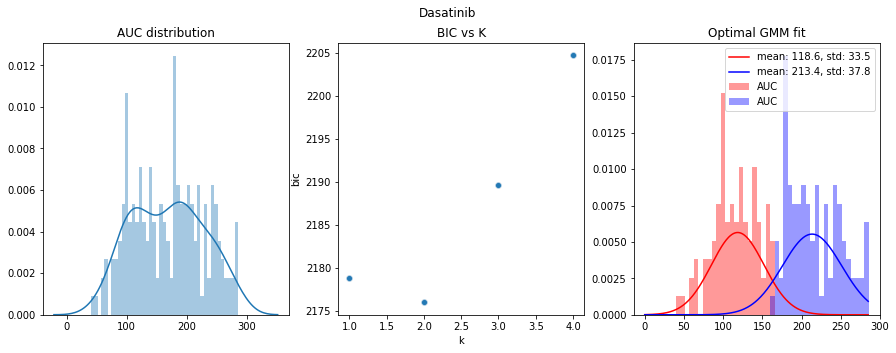

Elastic Net accuracy: 0.53
Elastic Net AUC: 0.50


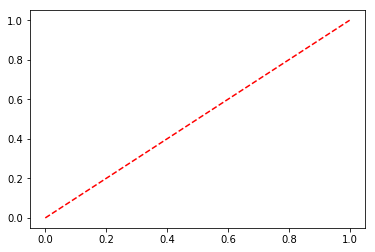

In [114]:
def build_RF_variant_model(aucs, var):
    '''
    
    '''
    

Dasatinib = aml_auc_w_var[aml_auc_w_var['inhibitor'] == 'Dasatinib']

print('Dasatinib auc and variants shape: %s' %str(Dasatinib.shape))

aucs = Dasatinib.auc.values.reshape(-1,1)
X = Dasatinib[genes]

Y = test_multimodal_fits(aucs, inhib='Dasatinib')

reg = ElasticNet(random_state=0).fit(X, Y)

yhat = reg.predict(X)

pred = yhat > 0.5 

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Elastic Net accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Elastic Net AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

#print(yhat)

#build_RF_variant_model(X,Y)

In [99]:
print(Y)

[1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0
 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0
 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1
 0 1 1 1 0 0 1 1 0 1 0 0]


------------------------------------------------
Inhibitor:  17-AAG (Tanespimycin)
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4443.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 154.50949899])
	Variances: array([ 2128.91559614])
Class counts: ['class 0: 422']


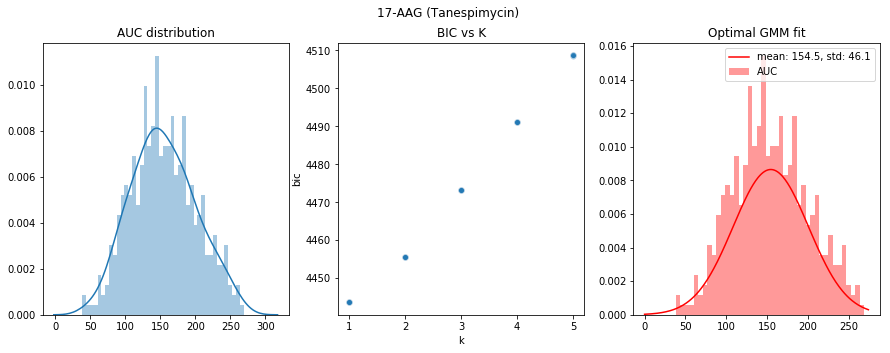

------------------------------------------------
Inhibitor:  A-674563
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 1 [BIC=4651.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 151.07041673])
	Variances: array([ 2329.23070046])
Class counts: ['class 0: 438']


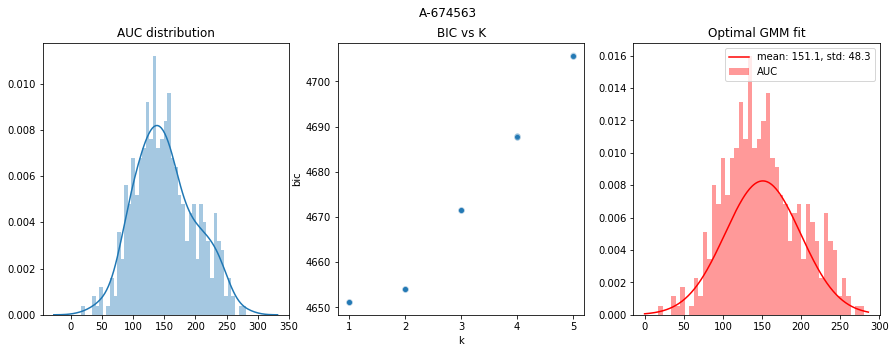

------------------------------------------------
Inhibitor:  Afatinib (BIBW-2992)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4401.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.66455291])
	Variances: array([ 1443.52059549])
Class counts: ['class 0: 434']


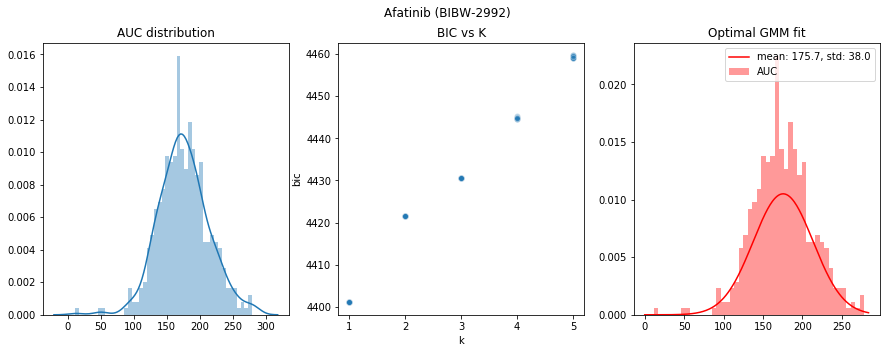

------------------------------------------------
Inhibitor:  Alisertib (MLN8237)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4329.8]
GMM fit:
	Mixture Weights: array([ 0.34328239,  0.65671761])
	Means: array([ 204.20260238,  246.26264189])
	Variances: array([ 1821.18446843,   475.64319411])
Class counts: ['class 0: 109', 'class 1: 327']


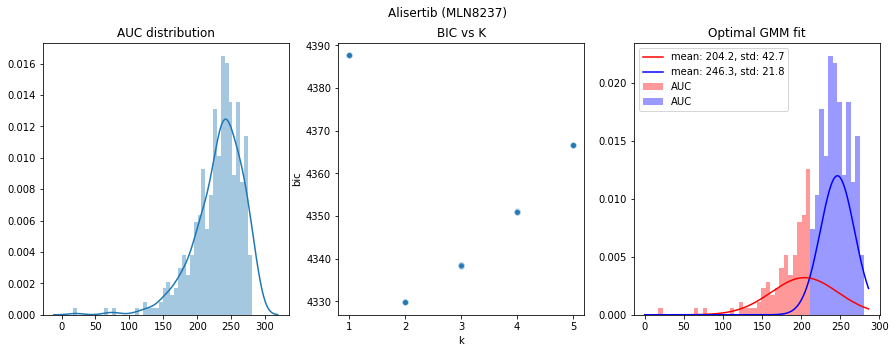

------------------------------------------------
Inhibitor:  AT7519
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 2 [BIC=4229.0]
GMM fit:
	Mixture Weights: array([ 0.75314284,  0.24685716])
	Means: array([ 124.75150735,  178.46550957])
	Variances: array([  563.09991858,  2338.81468744])
Class counts: ['class 0: 358', 'class 1: 64']


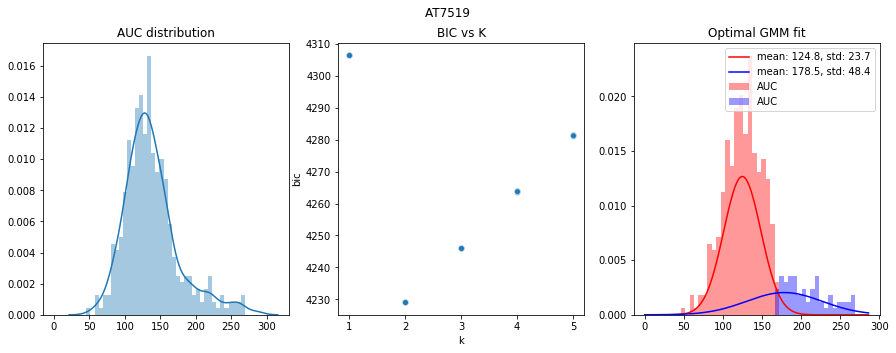

------------------------------------------------
Inhibitor:  Axitinib (AG-013736)
------------------------------------------------
Number of assays (aucs): 489
Optimal K: 1 [BIC=5142.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 196.08068388])
	Variances: array([ 2105.86622831])
Class counts: ['class 0: 489']


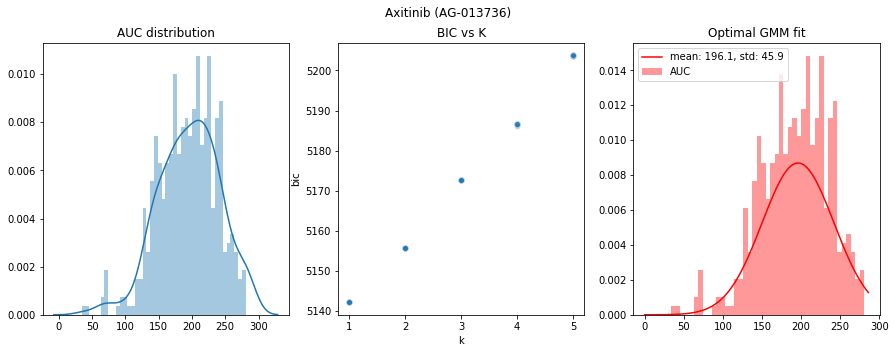

------------------------------------------------
Inhibitor:  AZD1480
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 2 [BIC=4387.8]
GMM fit:
	Mixture Weights: array([ 0.68375826,  0.31624174])
	Means: array([ 237.56460238,  191.00020832])
	Variances: array([  679.35869862,  2623.05171184])
Class counts: ['class 0: 347', 'class 1: 83']


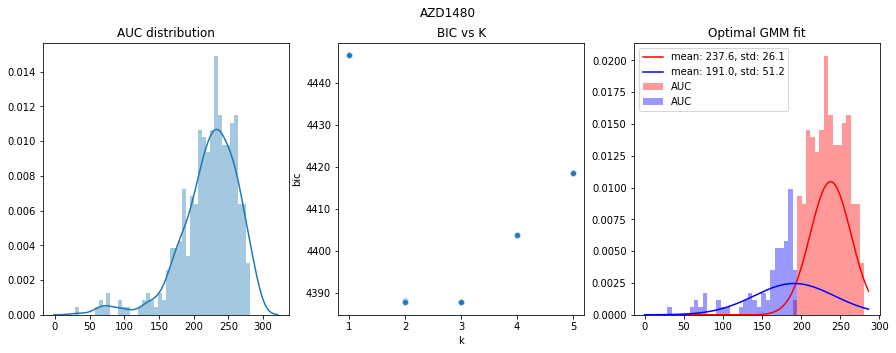

------------------------------------------------
Inhibitor:  Barasertib (AZD1152-HQPA)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 3 [BIC=4460.0]
GMM fit:
	Mixture Weights: array([ 0.42330403,  0.11282023,  0.46387574])
	Means: array([ 207.89923596,  132.78487016,  247.66057351])
	Variances: array([  785.09445571,  2142.92992008,   367.0611694 ])
Class counts: ['class 0: 166', 'class 1: 38', 'class 2: 230']


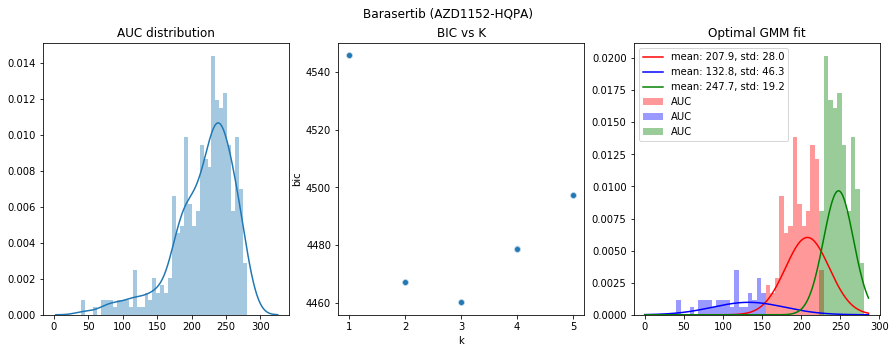

------------------------------------------------
Inhibitor:  BEZ235
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 1 [BIC=4549.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 155.1396563])
	Variances: array([ 2665.87541679])
Class counts: ['class 0: 423']


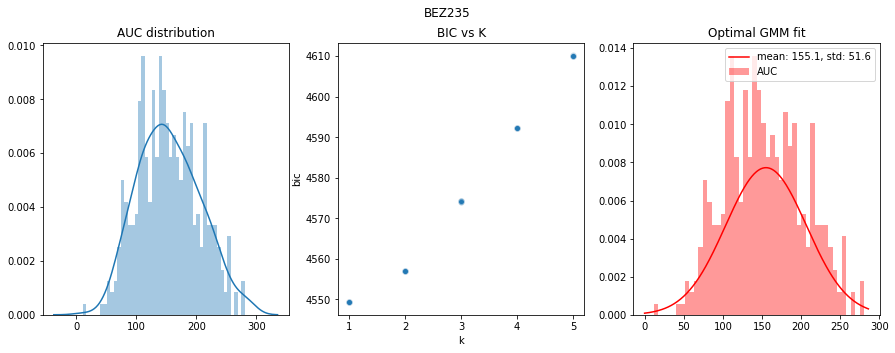

------------------------------------------------
Inhibitor:  BMS-345541
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4153.7]
GMM fit:
	Mixture Weights: array([ 0.6477877,  0.3522123])
	Means: array([ 239.06803525,  209.11838798])
	Variances: array([  323.31946996,  1320.81784771])
Class counts: ['class 0: 345', 'class 1: 91']


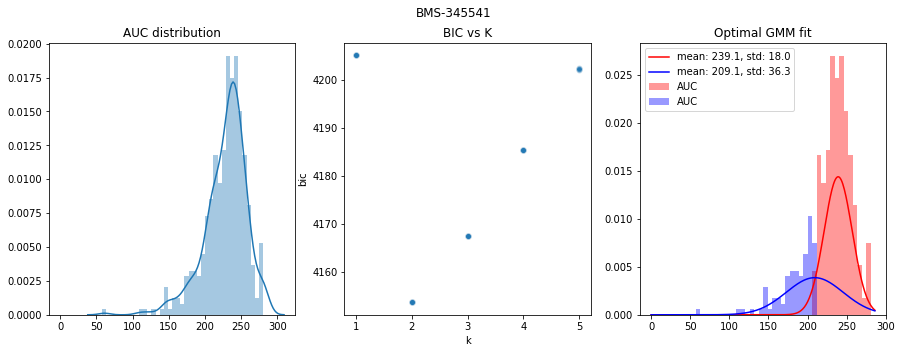

------------------------------------------------
Inhibitor:  Bortezomib (Velcade)
------------------------------------------------
Number of assays (aucs): 448
Optimal K: 1 [BIC=4913.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 158.67686228])
	Variances: array([ 3299.70585455])
Class counts: ['class 0: 448']


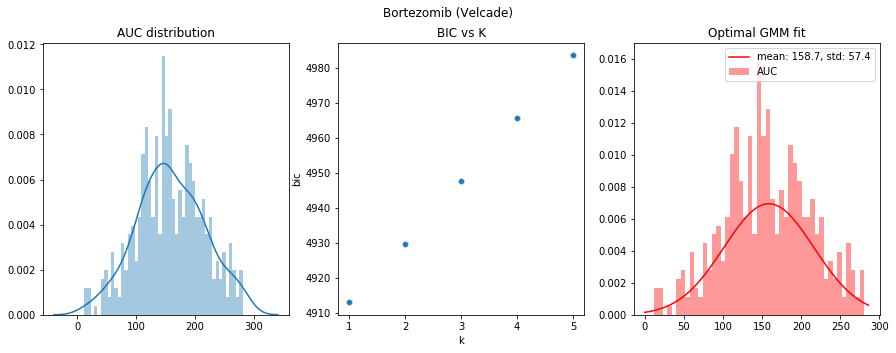

------------------------------------------------
Inhibitor:  Bosutinib (SKI-606)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 1 [BIC=4573.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 203.13102859])
	Variances: array([ 2048.55073521])
Class counts: ['class 0: 436']


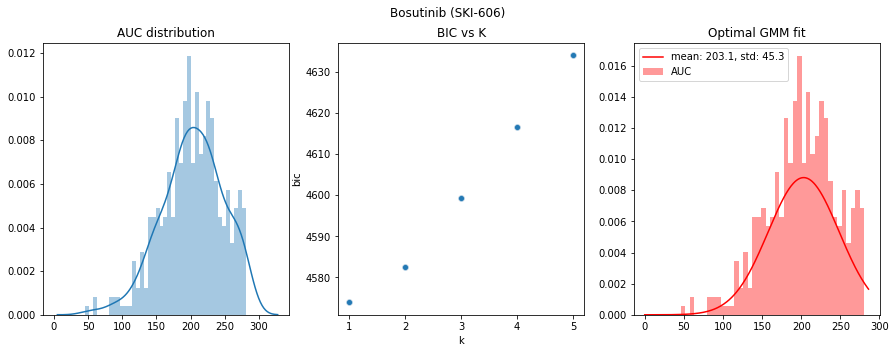

------------------------------------------------
Inhibitor:  Cabozantinib
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4578.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.10654432])
	Variances: array([ 2927.29076442])
Class counts: ['class 0: 422']


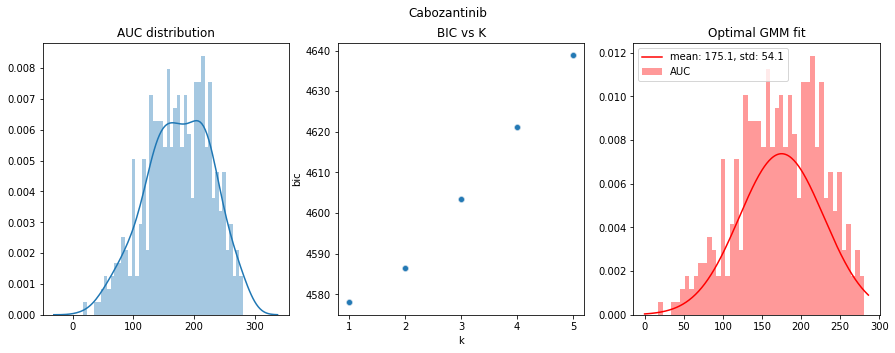

------------------------------------------------
Inhibitor:  Canertinib (CI-1033)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 2 [BIC=4345.4]
GMM fit:
	Mixture Weights: array([ 0.31247043,  0.68752957])
	Means: array([ 195.47543171,  231.11659019])
	Variances: array([ 2461.64893922,   638.25502618])
Class counts: ['class 0: 69', 'class 1: 363']


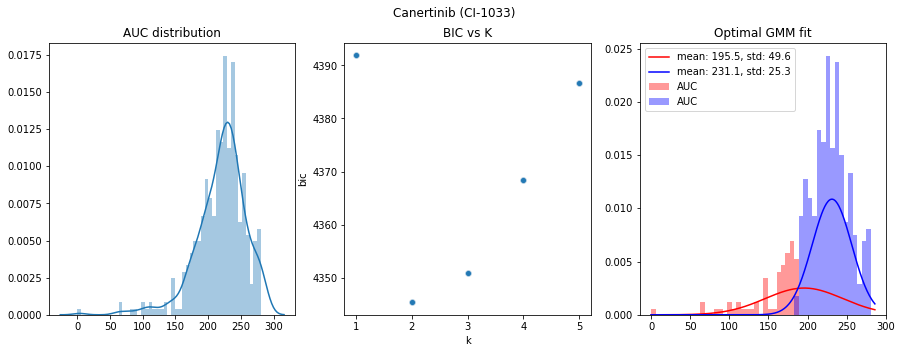

------------------------------------------------
Inhibitor:  Cediranib (AZD2171)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 4 [BIC=4164.4]
GMM fit:
	Mixture Weights: array([ 0.23640054,  0.05168128,  0.30876291,  0.40315527])
	Means: array([ 283.97250267,  127.72808084,  219.89165867,  257.04257597])
	Variances: array([    7.46829461,  2395.2821458 ,   507.29422741,   193.91635147])
Class counts: ['class 0: 109', 'class 1: 21', 'class 2: 126', 'class 3: 177']


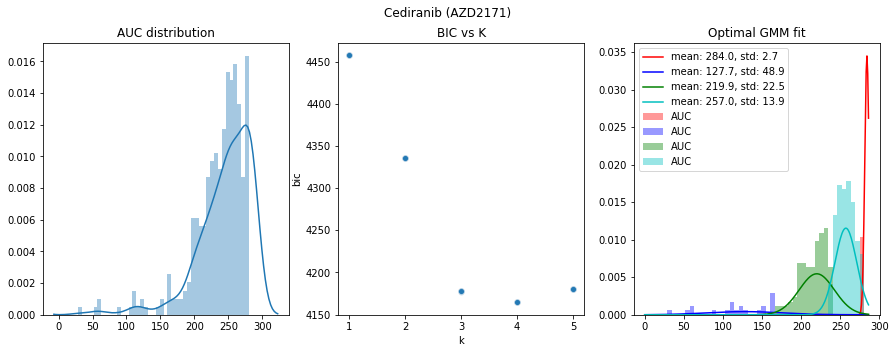

------------------------------------------------
Inhibitor:  CHIR-99021
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 4 [BIC=3099.0]
GMM fit:
	Mixture Weights: array([ 0.19935972,  0.26153107,  0.06532222,  0.47378699])
	Means: array([ 286.25399414,  255.4888756 ,  189.18746904,  279.27930301])
	Variances: array([  3.26304795e-03,   2.16456604e+02,   3.33118011e+03,
         2.79197612e+01])
Class counts: ['class 0: 87', 'class 1: 101', 'class 2: 21', 'class 3: 223']


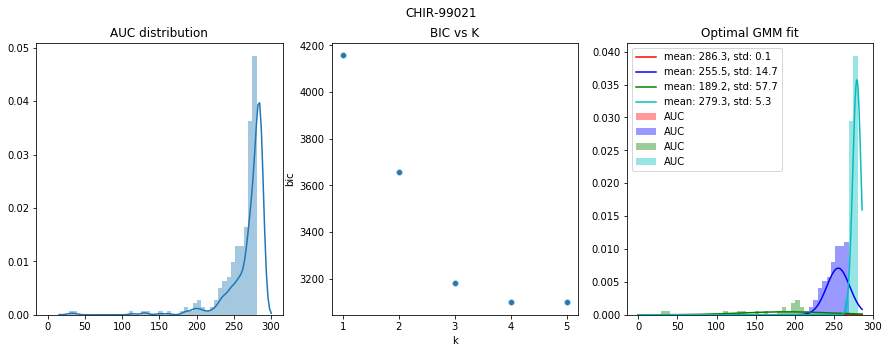

------------------------------------------------
Inhibitor:  CI-1040 (PD184352)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4621.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 186.16710688])
	Variances: array([ 2399.10252514])
Class counts: ['class 0: 434']


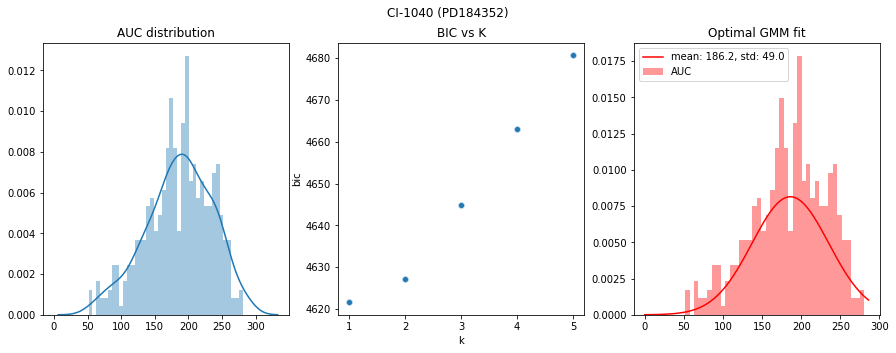

------------------------------------------------
Inhibitor:  Crenolanib
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 2 [BIC=4640.8]
GMM fit:
	Mixture Weights: array([ 0.56058703,  0.43941297])
	Means: array([ 248.24111318,  177.61408018])
	Variances: array([  655.29874179,  2013.7339333 ])
Class counts: ['class 0: 266', 'class 1: 173']


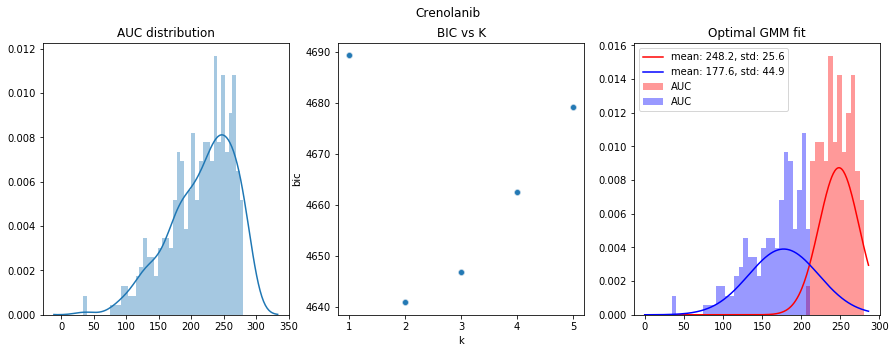

------------------------------------------------
Inhibitor:  Crizotinib (PF-2341066)
------------------------------------------------
Number of assays (aucs): 497
Optimal K: 1 [BIC=5065.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 204.51331279])
	Variances: array([ 1524.50444563])
Class counts: ['class 0: 497']


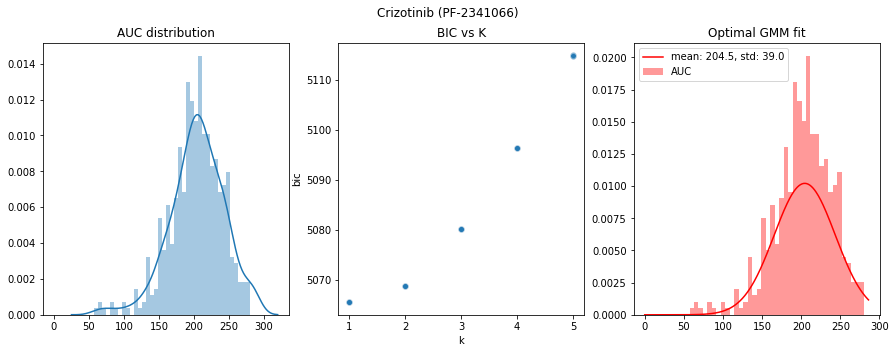

------------------------------------------------
Inhibitor:  CYT387
------------------------------------------------
Number of assays (aucs): 435
Optimal K: 1 [BIC=4568.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 179.54867492])
	Variances: array([ 2072.83764801])
Class counts: ['class 0: 435']


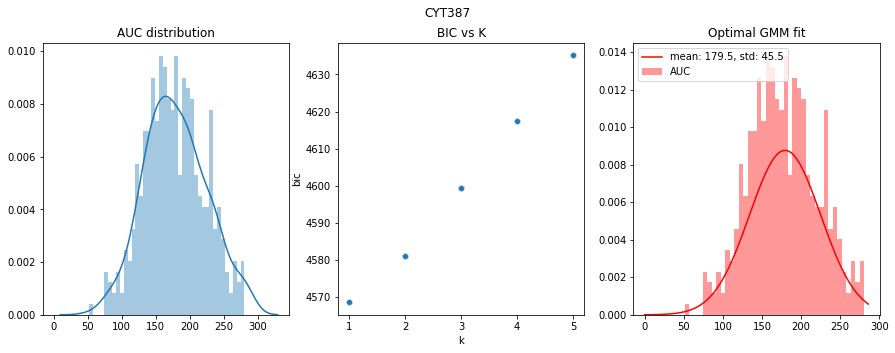

------------------------------------------------
Inhibitor:  Dasatinib
------------------------------------------------
Number of assays (aucs): 500
Optimal K: 2 [BIC=5491.2]
GMM fit:
	Mixture Weights: array([ 0.46782025,  0.53217975])
	Means: array([ 123.55335351,  217.77686359])
	Variances: array([ 1388.06017329,  1257.28478297])
Class counts: ['class 0: 224', 'class 1: 276']


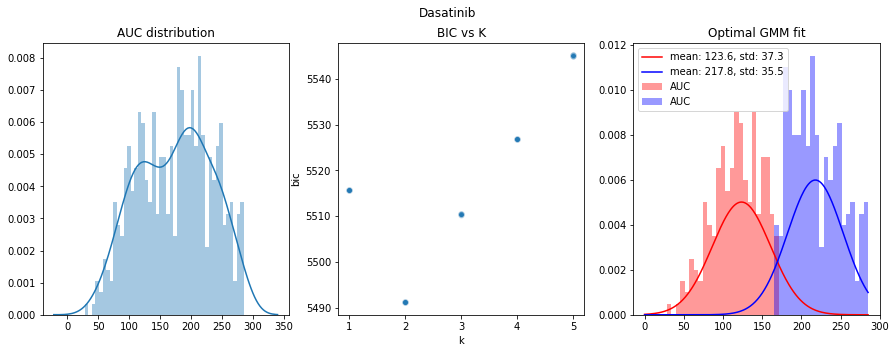

------------------------------------------------
Inhibitor:  Doramapimod (BIRB 796)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4714.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 173.64940363])
	Variances: array([ 3121.23762535])
Class counts: ['class 0: 432']


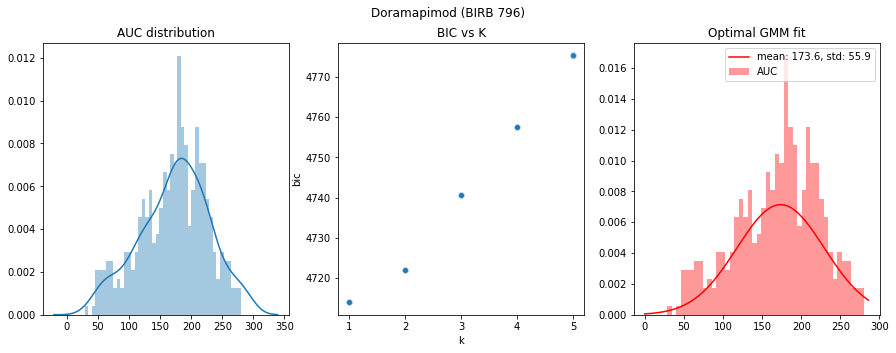

------------------------------------------------
Inhibitor:  Dovitinib (CHIR-258)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4654.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 156.66310314])
	Variances: array([ 2589.11075512])
Class counts: ['class 0: 434']


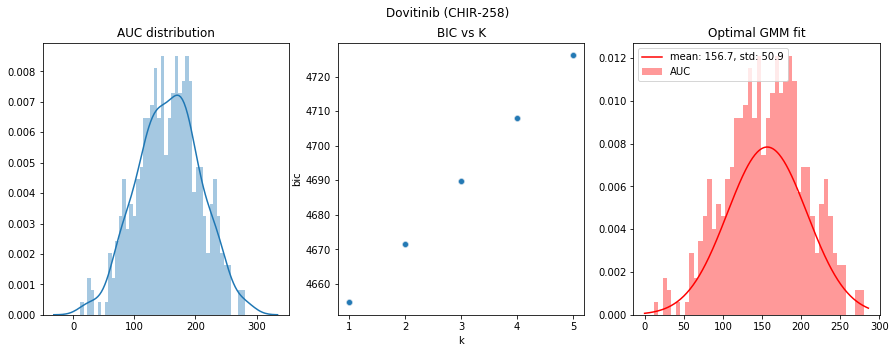

------------------------------------------------
Inhibitor:  Elesclomol
------------------------------------------------
Number of assays (aucs): 401
Optimal K: 3 [BIC=4037.7]
GMM fit:
	Mixture Weights: array([ 0.51174539,  0.39585498,  0.09239963])
	Means: array([  26.350298  ,   66.66850544,  203.44968902])
	Variances: array([  166.22601469,   612.43965939,  2510.66009017])
Class counts: ['class 0: 221', 'class 1: 144', 'class 2: 36']


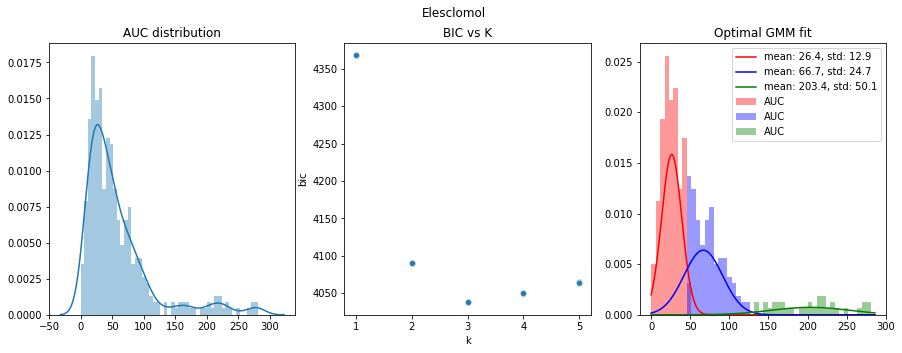

------------------------------------------------
Inhibitor:  Erlotinib
------------------------------------------------
Number of assays (aucs): 494
Optimal K: 2 [BIC=4859.8]
GMM fit:
	Mixture Weights: array([ 0.61873948,  0.38126052])
	Means: array([ 245.28723167,  206.3491596 ])
	Variances: array([  454.2151368 ,  1366.94034476])
Class counts: ['class 0: 360', 'class 1: 134']


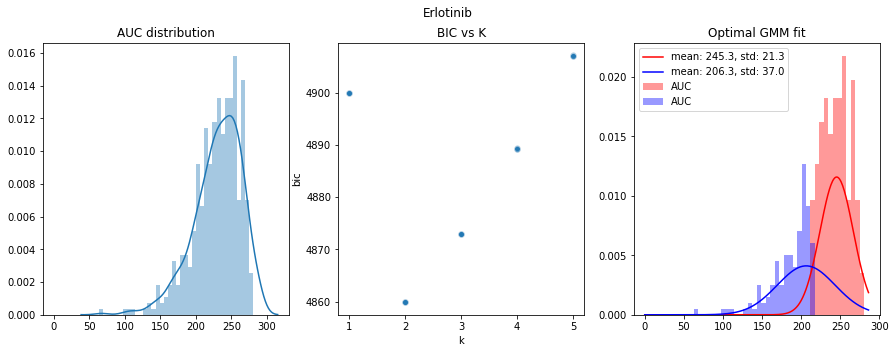

------------------------------------------------
Inhibitor:  Flavopiridol
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 2 [BIC=4672.4]
GMM fit:
	Mixture Weights: array([ 0.66508816,  0.33491184])
	Means: array([ 103.66651482,  186.28874937])
	Variances: array([  988.81044947,  3253.09454755])
Class counts: ['class 0: 318', 'class 1: 115']


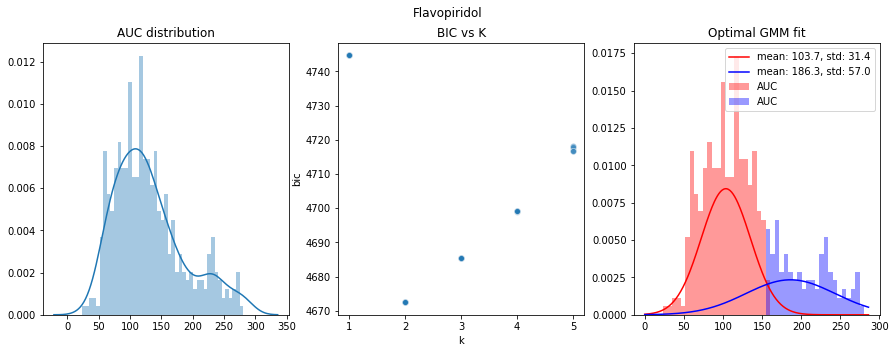

------------------------------------------------
Inhibitor:  Foretinib (XL880)
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 1 [BIC=4644.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 130.15626445])
	Variances: array([ 2791.87918259])
Class counts: ['class 0: 430']


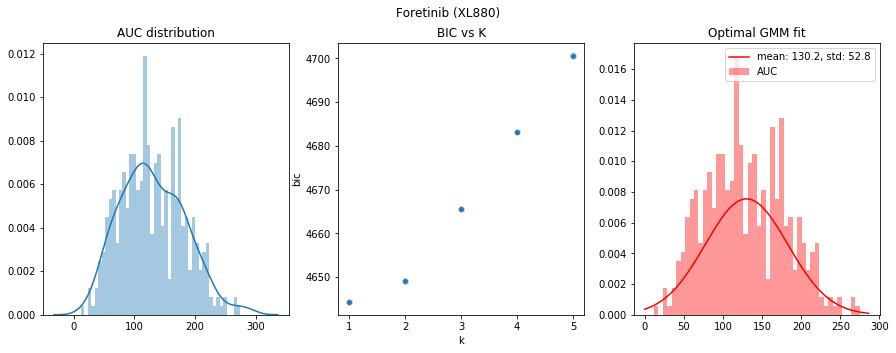

------------------------------------------------
Inhibitor:  GDC-0879
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 4 [BIC=2652.8]
GMM fit:
	Mixture Weights: array([ 0.03263325,  0.53577316,  0.28795058,  0.14364301])
	Means: array([ 156.32321761,  278.26202816,  286.26518616,  242.00450313])
	Variances: array([  2.37646334e+03,   5.89027440e+01,   1.60742385e-03,
         5.72554080e+02])
Class counts: ['class 0: 11', 'class 1: 242', 'class 2: 126', 'class 3: 54']


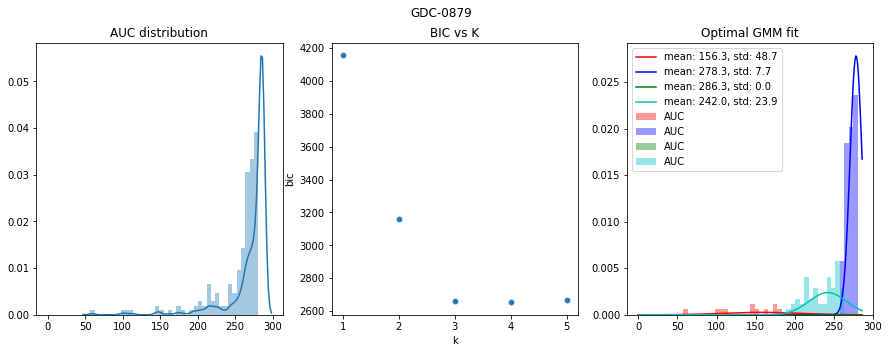

------------------------------------------------
Inhibitor:  GDC-0941
------------------------------------------------
Number of assays (aucs): 403
Optimal K: 1 [BIC=4211.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 155.88303782])
	Variances: array([ 1964.208886])
Class counts: ['class 0: 403']


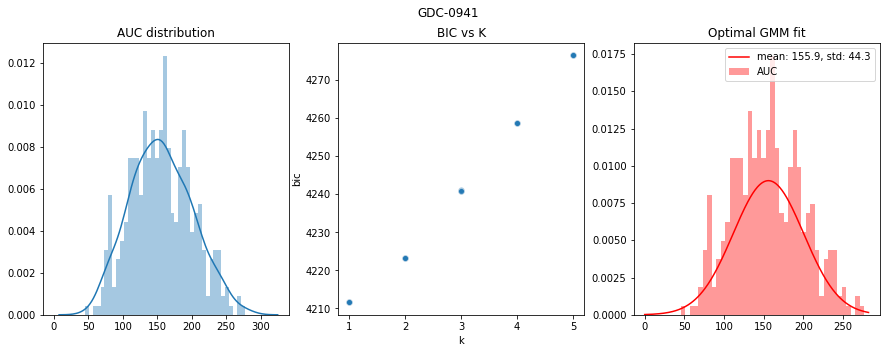

------------------------------------------------
Inhibitor:  Gefitinib
------------------------------------------------
Number of assays (aucs): 492
Optimal K: 2 [BIC=4781.7]
GMM fit:
	Mixture Weights: array([ 0.66870742,  0.33129258])
	Means: array([ 253.3594795 ,  216.04175397])
	Variances: array([  403.86181731,  1573.84847907])
Class counts: ['class 0: 390', 'class 1: 102']


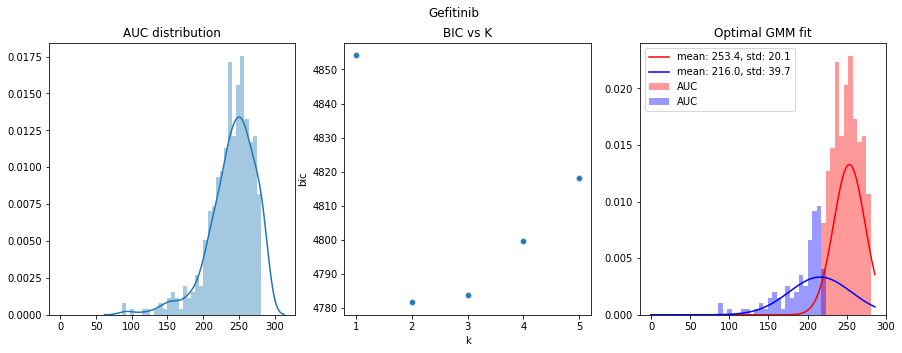

------------------------------------------------
Inhibitor:  GSK-1838705A
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4379.6]
GMM fit:
	Mixture Weights: array([ 0.64441178,  0.35558822])
	Means: array([ 226.23377434,  193.51224229])
	Variances: array([  762.09370287,  2589.28618581])
Class counts: ['class 0: 356', 'class 1: 73']


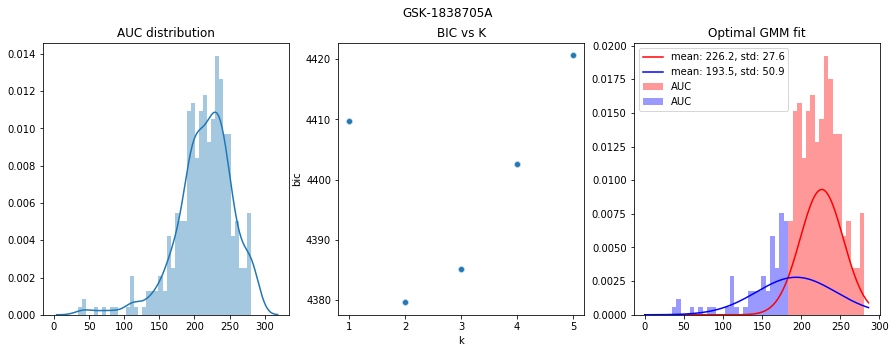

------------------------------------------------
Inhibitor:  GSK-1904529A
------------------------------------------------
Number of assays (aucs): 424
Optimal K: 2 [BIC=4170.1]
GMM fit:
	Mixture Weights: array([ 0.70313758,  0.29686242])
	Means: array([ 254.02621907,  201.15845045])
	Variances: array([  364.60097096,  1884.17926715])
Class counts: ['class 0: 328', 'class 1: 96']


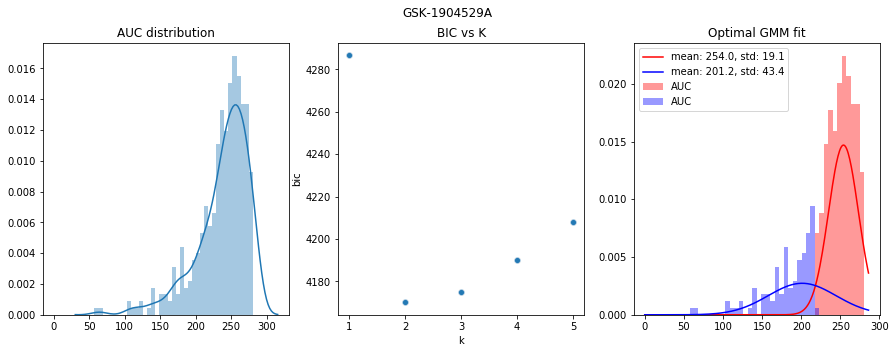

------------------------------------------------
Inhibitor:  GSK690693
------------------------------------------------
Number of assays (aucs): 424
Optimal K: 3 [BIC=4242.4]
GMM fit:
	Mixture Weights: array([ 0.46017142,  0.42038574,  0.11944283])
	Means: array([ 260.41512784,  224.76638262,  177.41892221])
	Variances: array([  270.75592078,   806.35712071,  3068.87989479])
Class counts: ['class 0: 234', 'class 1: 165', 'class 2: 25']


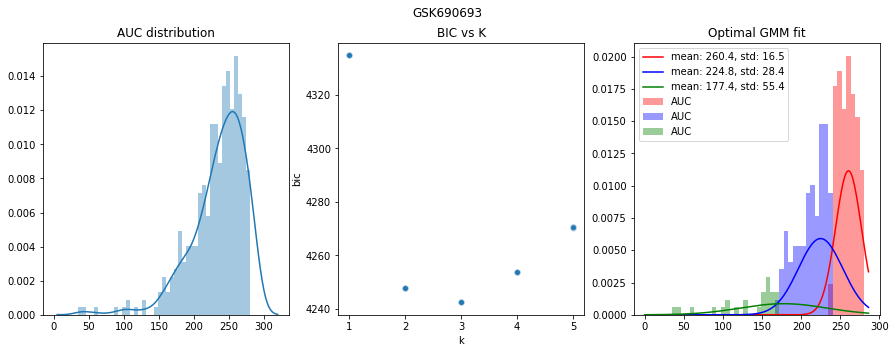

------------------------------------------------
Inhibitor:  GW-2580
------------------------------------------------
Number of assays (aucs): 417
Optimal K: 1 [BIC=4276.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 213.82657202])
	Variances: array([ 1616.7423152])
Class counts: ['class 0: 417']


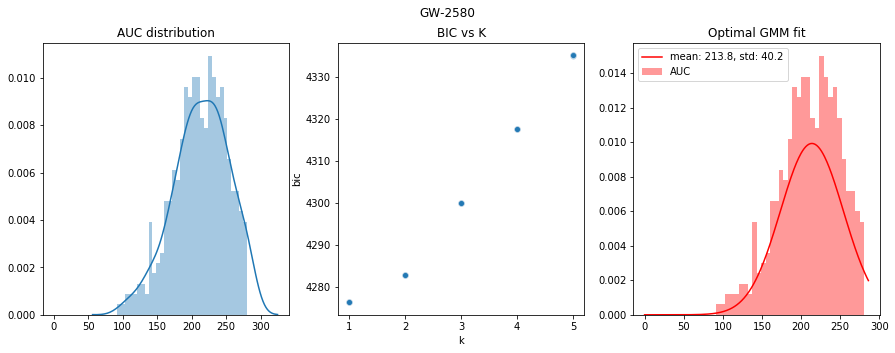

------------------------------------------------
Inhibitor:  H-89
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 3 [BIC=4354.2]
GMM fit:
	Mixture Weights: array([ 0.44556323,  0.07765988,  0.4767769 ])
	Means: array([ 219.96118636,  132.16485483,  260.76639285])
	Variances: array([  640.49591888,  2634.86588413,   245.85984071])
Class counts: ['class 0: 190', 'class 1: 24', 'class 2: 219']


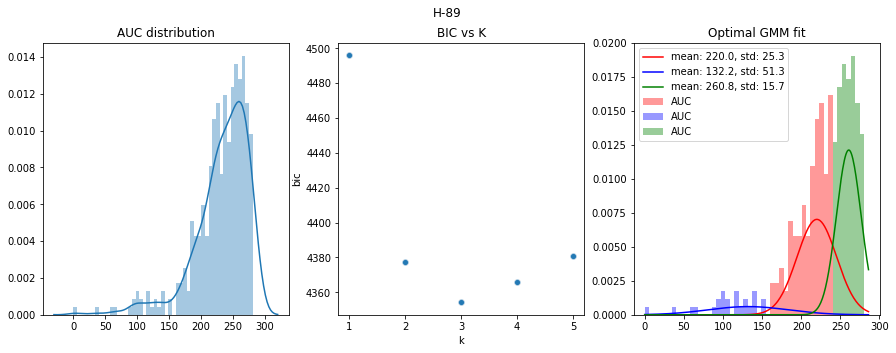

------------------------------------------------
Inhibitor:  Ibrutinib (PCI-32765)
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 4 [BIC=4457.9]
GMM fit:
	Mixture Weights: array([ 0.27262629,  0.15585869,  0.28047557,  0.29103945])
	Means: array([ 263.55051237,  141.93942592,  196.81052256,  210.90953113])
	Variances: array([  212.01352165,  1849.94058516,   871.30855604,   821.13506966])
Class counts: ['class 0: 135', 'class 1: 54', 'class 2: 120', 'class 3: 111']


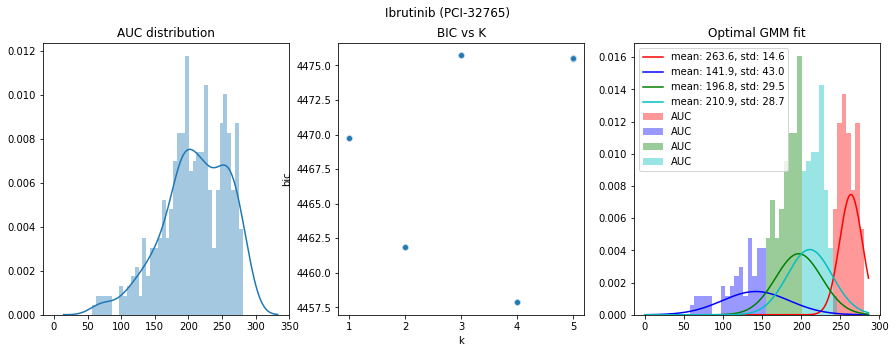

------------------------------------------------
Inhibitor:  Idelalisib
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 1 [BIC=4520.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 192.43172531])
	Variances: array([ 2143.73346977])
Class counts: ['class 0: 429']


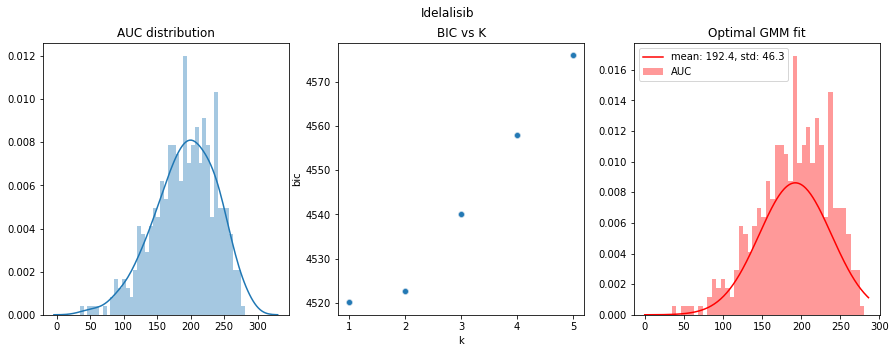

------------------------------------------------
Inhibitor:  Imatinib
------------------------------------------------
Number of assays (aucs): 511
Optimal K: 3 [BIC=5165.5]
GMM fit:
	Mixture Weights: array([ 0.43545984,  0.43325213,  0.13128803])
	Means: array([ 252.6459565 ,  227.41765714,  172.61882634])
	Variances: array([  470.01793071,   881.99645221,  3189.19280153])
Class counts: ['class 0: 275', 'class 1: 196', 'class 2: 40']


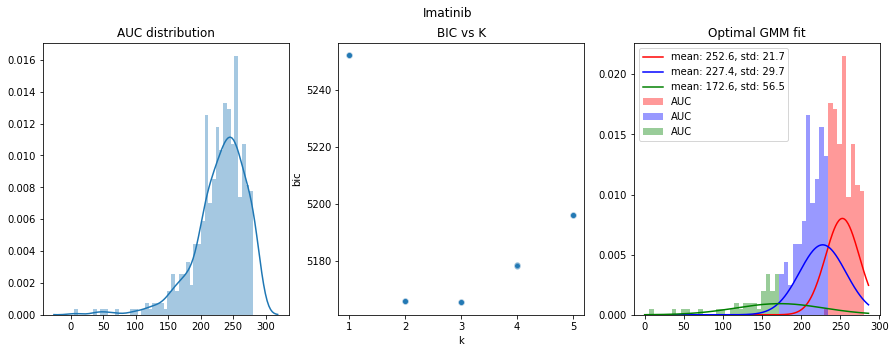

------------------------------------------------
Inhibitor:  INK-128
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 1 [BIC=4684.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 128.60194517])
	Variances: array([ 2642.44890348])
Class counts: ['class 0: 436']


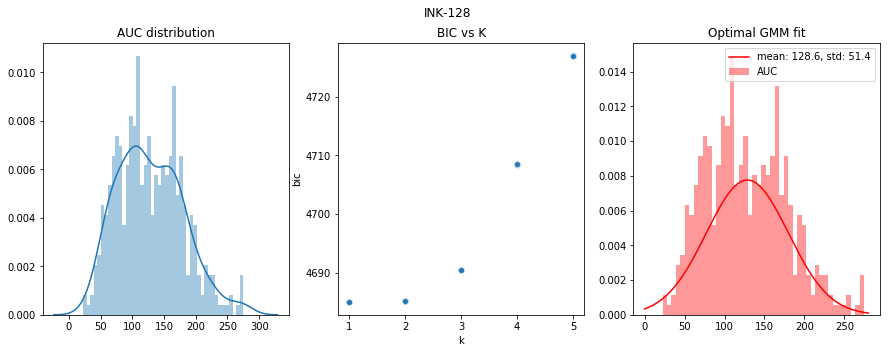

------------------------------------------------
Inhibitor:  JAK Inhibitor I
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 1 [BIC=4573.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 176.23799769])
	Variances: array([ 2198.36538808])
Class counts: ['class 0: 433']


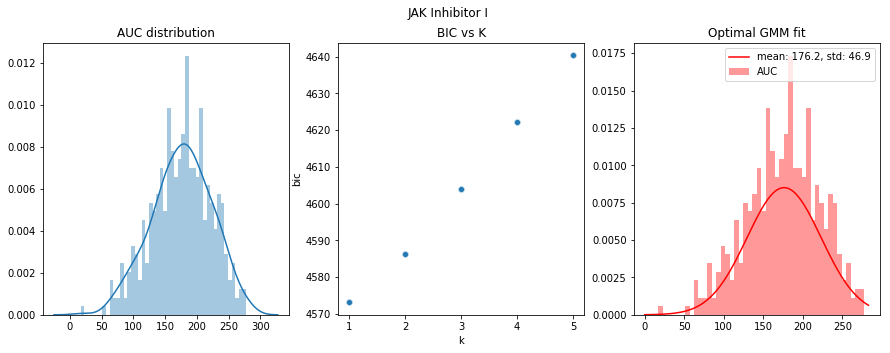

------------------------------------------------
Inhibitor:  JNJ-28312141
------------------------------------------------
Number of assays (aucs): 419
Optimal K: 1 [BIC=4639.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 143.79579035])
	Variances: array([ 3661.97483019])
Class counts: ['class 0: 419']


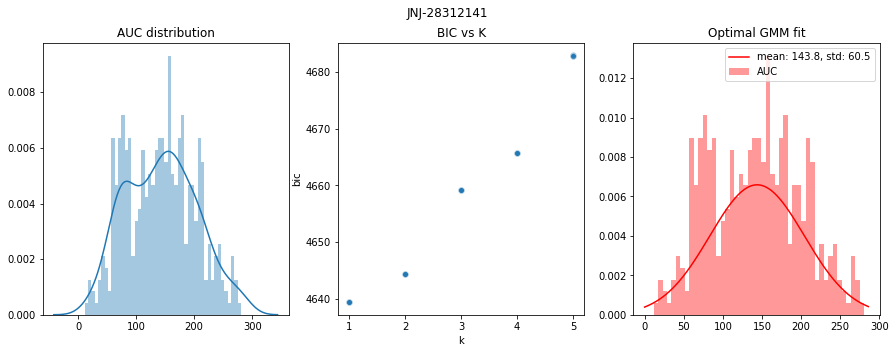

------------------------------------------------
Inhibitor:  JNJ-38877605
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 2 [BIC=4131.4]
GMM fit:
	Mixture Weights: array([ 0.6485401,  0.3514599])
	Means: array([ 251.43303916,  211.76297738])
	Variances: array([  358.82681272,  1494.04817435])
Class counts: ['class 0: 321', 'class 1: 104']


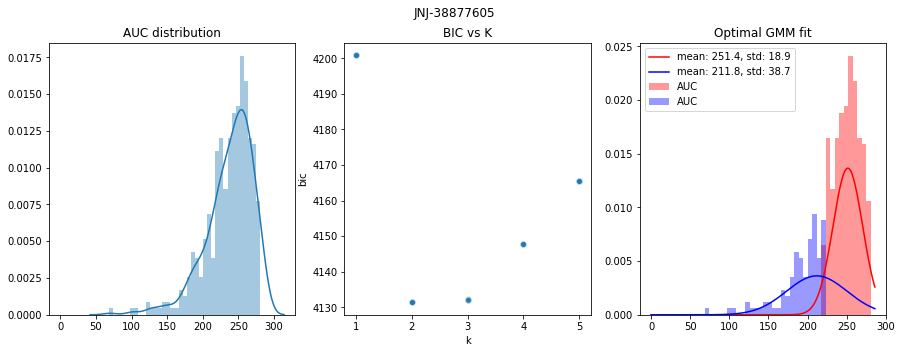

------------------------------------------------
Inhibitor:  JNJ-7706621
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 2 [BIC=4229.8]
GMM fit:
	Mixture Weights: array([ 0.37723995,  0.62276005])
	Means: array([ 215.19081449,  246.25624382])
	Variances: array([ 1161.36983171,   407.01468393])
Class counts: ['class 0: 107', 'class 1: 332']


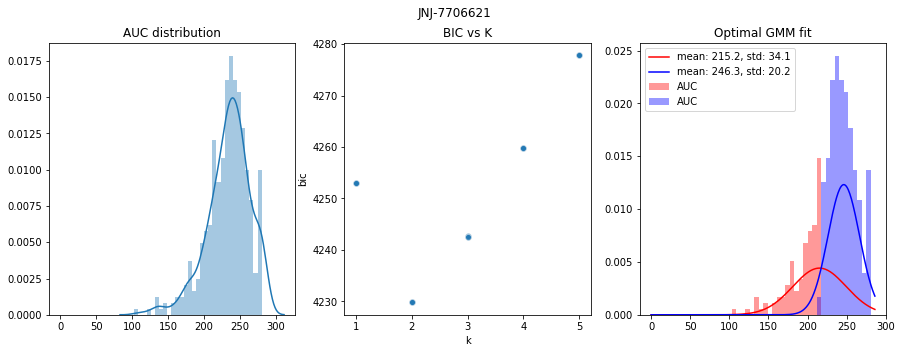

------------------------------------------------
Inhibitor:  KI20227
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 3 [BIC=4749.2]
GMM fit:
	Mixture Weights: array([ 0.3171119 ,  0.27280464,  0.41008347])
	Means: array([ 137.95920933,  256.8800191 ,  175.77865303])
	Variances: array([ 2497.75769925,   424.28392808,  1486.6370125 ])
Class counts: ['class 0: 99', 'class 1: 129', 'class 2: 202']


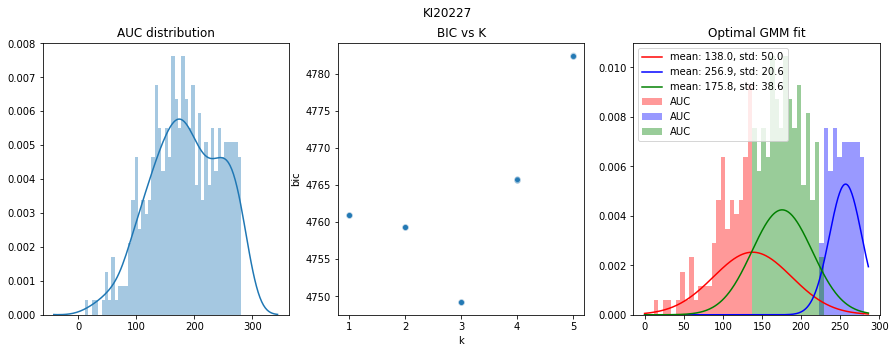

------------------------------------------------
Inhibitor:  KU-55933
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 4 [BIC=4233.9]
GMM fit:
	Mixture Weights: array([ 0.2168071 ,  0.22699107,  0.52011937,  0.03608246])
	Means: array([ 280.14895141,  200.92790729,  245.93409938,   98.32525447])
	Variances: array([  27.28164358,  944.71782655,  279.2877125 ,  857.09319743])
Class counts: ['class 0: 102', 'class 1: 74', 'class 2: 235', 'class 3: 14']


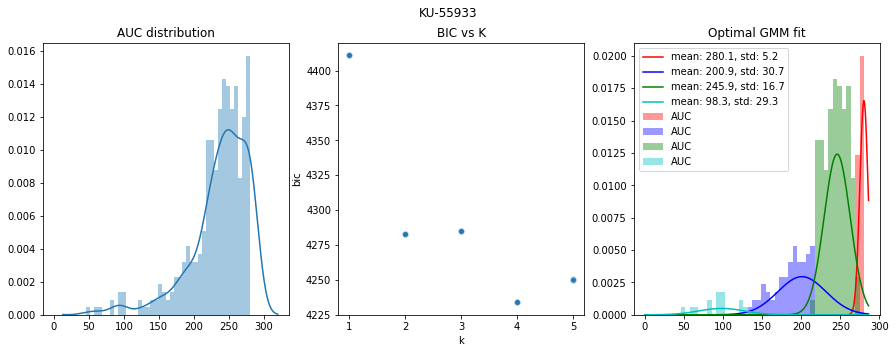

------------------------------------------------
Inhibitor:  KW-2449
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4616.7]
GMM fit:
	Mixture Weights: array([ 0.36968549,  0.63031451])
	Means: array([ 158.53025873,  229.26869132])
	Variances: array([ 3259.32200637,  1016.70709533])
Class counts: ['class 0: 124', 'class 1: 305']


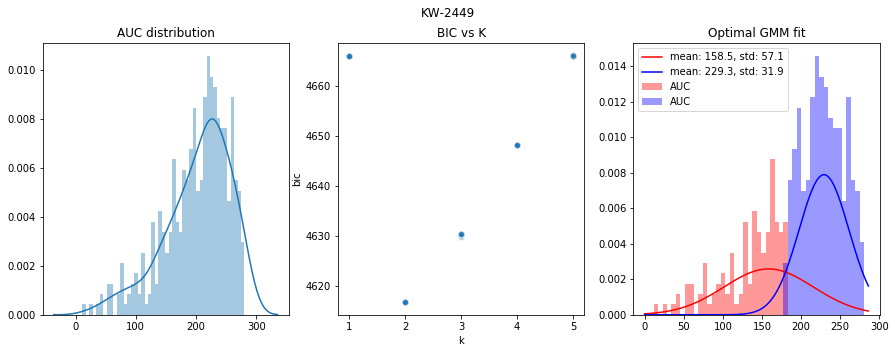

------------------------------------------------
Inhibitor:  Lapatinib
------------------------------------------------
Number of assays (aucs): 485
Optimal K: 2 [BIC=4735.0]
GMM fit:
	Mixture Weights: array([ 0.37159515,  0.62840485])
	Means: array([ 212.13786003,  243.08928529])
	Variances: array([ 1530.34760838,   455.4886863 ])
Class counts: ['class 0: 101', 'class 1: 384']


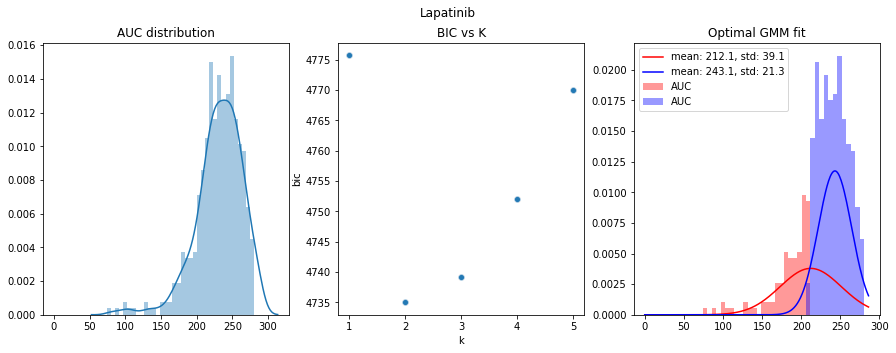

------------------------------------------------
Inhibitor:  Linifanib (ABT-869)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4685.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 195.94696577])
	Variances: array([ 2920.83261464])
Class counts: ['class 0: 432']


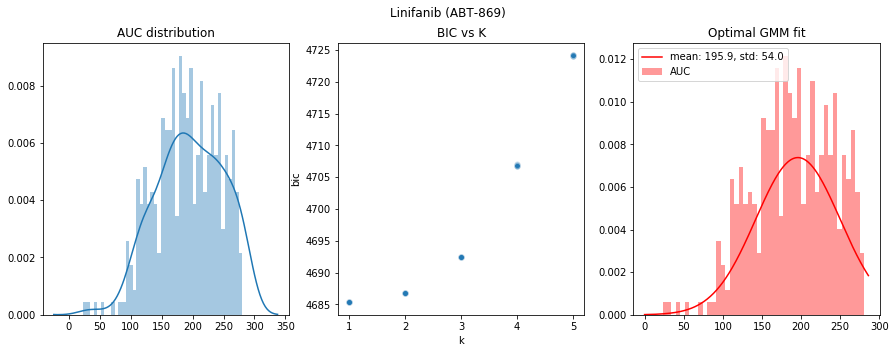

------------------------------------------------
Inhibitor:  LY-333531
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 1 [BIC=4394.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 214.16070378])
	Variances: array([ 1266.78532184])
Class counts: ['class 0: 439']


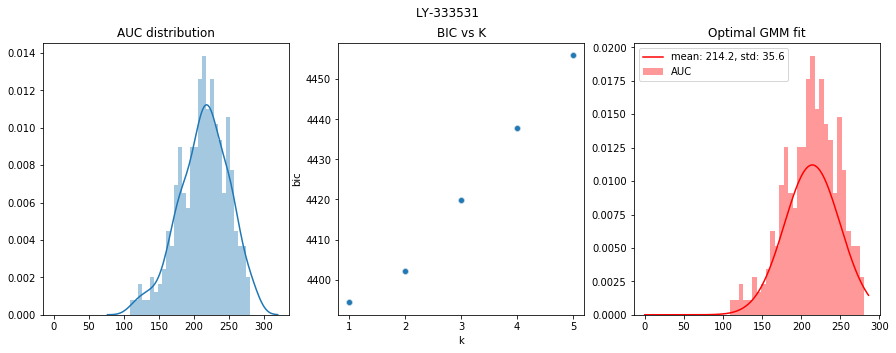

------------------------------------------------
Inhibitor:  Masitinib (AB-1010)
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 2 [BIC=4474.0]
GMM fit:
	Mixture Weights: array([ 0.55508354,  0.44491646])
	Means: array([ 222.86560546,  175.25690805])
	Variances: array([ 1032.22919725,  2272.65262218])
Class counts: ['class 0: 280', 'class 1: 145']


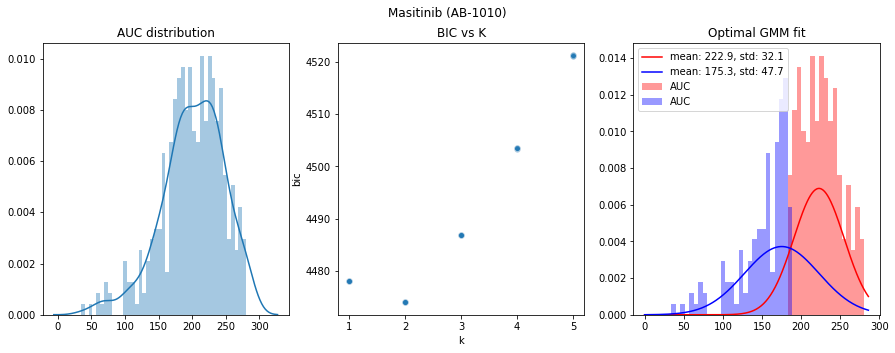

------------------------------------------------
Inhibitor:  MGCD-265
------------------------------------------------
Number of assays (aucs): 421
Optimal K: 2 [BIC=4437.4]
GMM fit:
	Mixture Weights: array([ 0.60255465,  0.39744535])
	Means: array([ 226.71869457,  170.23319985])
	Variances: array([  883.29490895,  2583.86128434])
Class counts: ['class 0: 292', 'class 1: 129']


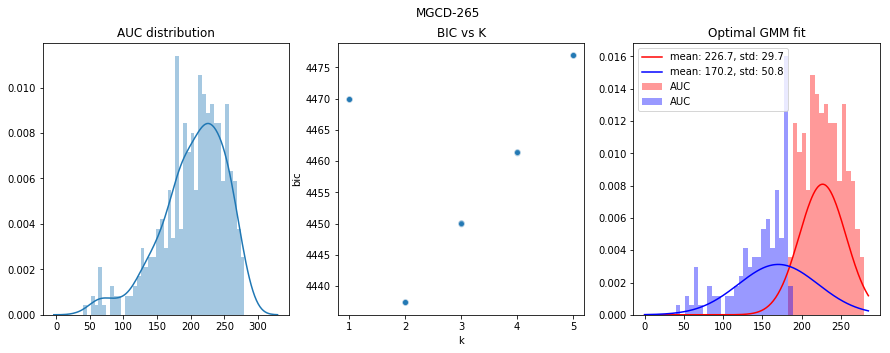

------------------------------------------------
Inhibitor:  Midostaurin
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 2 [BIC=4531.6]
GMM fit:
	Mixture Weights: array([ 0.58642892,  0.41357108])
	Means: array([ 227.68028735,  166.49952623])
	Variances: array([ 1126.34757812,  2602.54914629])
Class counts: ['class 0: 291', 'class 1: 132']


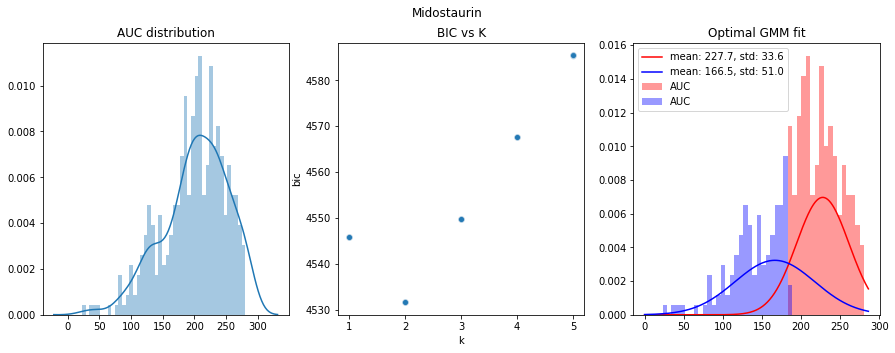

------------------------------------------------
Inhibitor:  MK-2206
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 2 [BIC=4559.8]
GMM fit:
	Mixture Weights: array([ 0.4975549,  0.5024451])
	Means: array([ 166.25231963,  245.49304086])
	Variances: array([ 2400.12029882,   818.71014722])
Class counts: ['class 0: 192', 'class 1: 228']


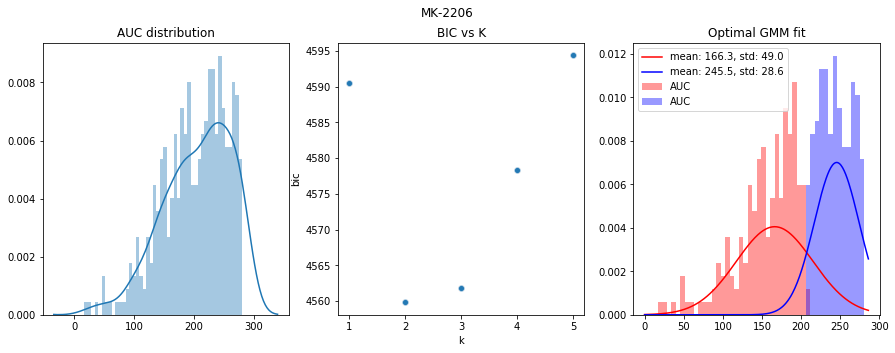

------------------------------------------------
Inhibitor:  MLN120B
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4298.1]
GMM fit:
	Mixture Weights: array([ 0.70604978,  0.29395022])
	Means: array([ 246.5592976 ,  198.04981999])
	Variances: array([  512.24469362,  2515.00648811])
Class counts: ['class 0: 348', 'class 1: 81']


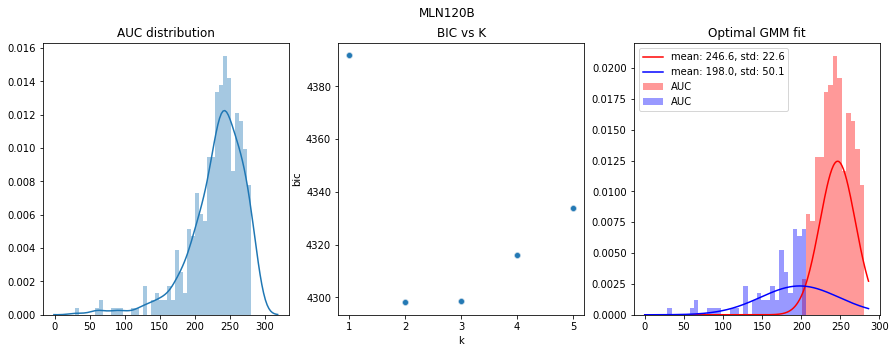

------------------------------------------------
Inhibitor:  MLN8054
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 3 [BIC=4061.0]
GMM fit:
	Mixture Weights: array([ 0.42421821,  0.53446289,  0.04131891])
	Means: array([ 234.11493397,  267.65559879,  153.44440356])
	Variances: array([  536.75459877,   172.54266119,  2563.30679427])
Class counts: ['class 0: 159', 'class 1: 255', 'class 2: 13']


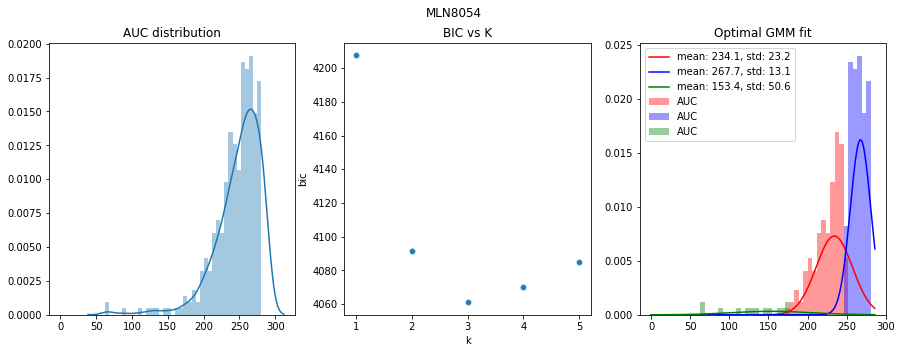

------------------------------------------------
Inhibitor:  Motesanib (AMG-706)
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 4 [BIC=4475.2]
GMM fit:
	Mixture Weights: array([ 0.41972589,  0.29617478,  0.01386803,  0.2702313 ])
	Means: array([ 235.59749621,  175.80564804,   36.11699075,  277.76626574])
	Variances: array([ 529.63868223,  890.28981989,  356.8966111 ,   64.35017609])
Class counts: ['class 0: 177', 'class 1: 122', 'class 2: 6', 'class 3: 125']


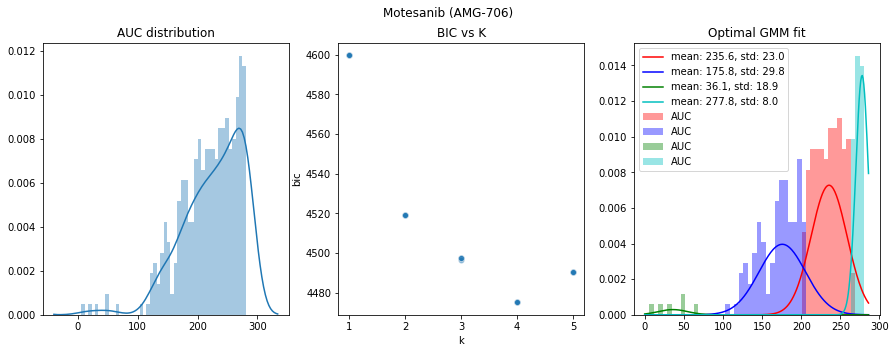

------------------------------------------------
Inhibitor:  Neratinib (HKI-272)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 1 [BIC=4559.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 161.97390563])
	Variances: array([ 2127.98147262])
Class counts: ['class 0: 433']


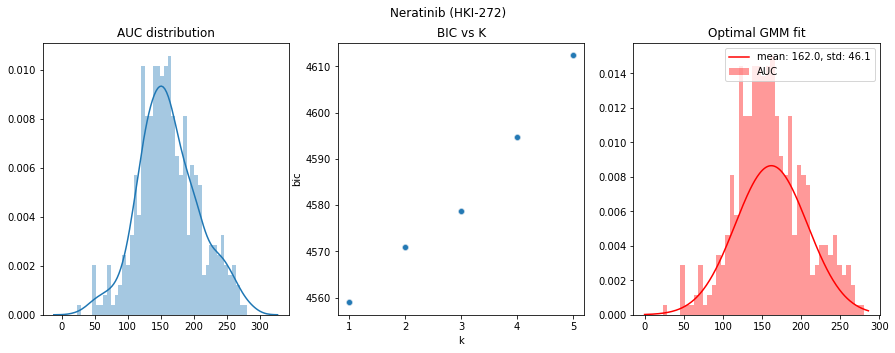

------------------------------------------------
Inhibitor:  NF-kB Activation Inhibitor
------------------------------------------------
Number of assays (aucs): 418
Optimal K: 2 [BIC=4488.9]
GMM fit:
	Mixture Weights: array([ 0.56793555,  0.43206445])
	Means: array([ 236.13132438,  169.84052048])
	Variances: array([ 1080.33285254,  2391.66716612])
Class counts: ['class 0: 263', 'class 1: 155']


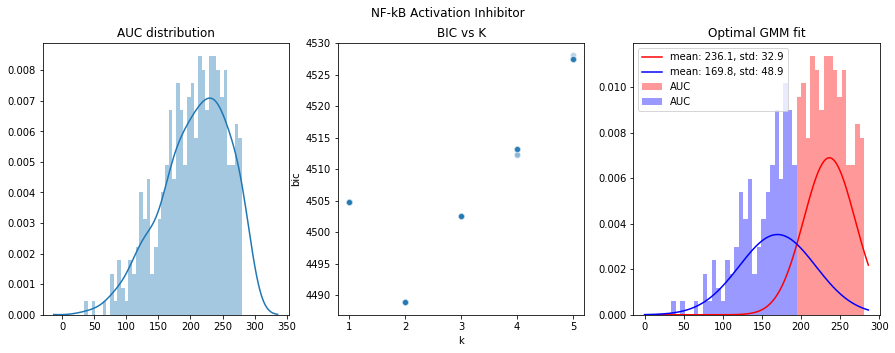

------------------------------------------------
Inhibitor:  Nilotinib
------------------------------------------------
Number of assays (aucs): 495
Optimal K: 2 [BIC=5019.3]
GMM fit:
	Mixture Weights: array([ 0.50233536,  0.49766464])
	Means: array([ 199.7455403 ,  255.40790252])
	Variances: array([ 1001.10418362,   462.24300534])
Class counts: ['class 0: 237', 'class 1: 258']


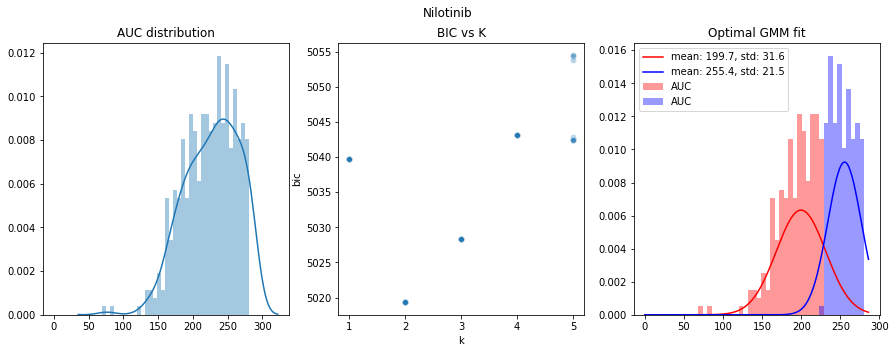

------------------------------------------------
Inhibitor:  NVP-ADW742
------------------------------------------------
Number of assays (aucs): 415
Optimal K: 2 [BIC=4184.6]
GMM fit:
	Mixture Weights: array([ 0.61551839,  0.38448161])
	Means: array([ 231.11355308,  197.1292676 ])
	Variances: array([  648.79332419,  1978.51115865])
Class counts: ['class 0: 321', 'class 1: 94']


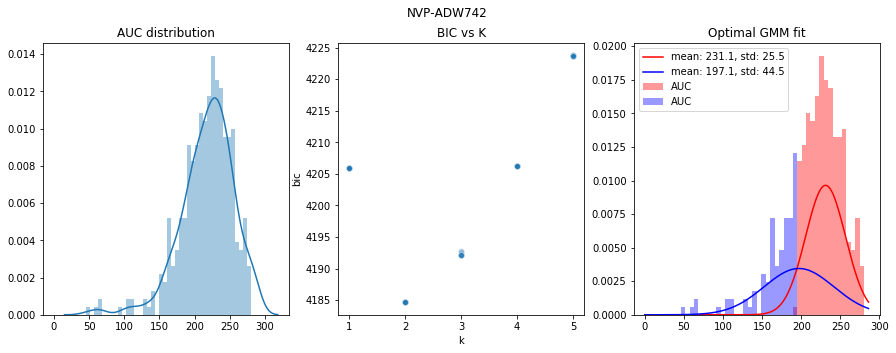

------------------------------------------------
Inhibitor:  NVP-TAE684
------------------------------------------------
Number of assays (aucs): 431
Optimal K: 2 [BIC=4590.9]
GMM fit:
	Mixture Weights: array([ 0.54510829,  0.45489171])
	Means: array([ 221.22073727,  167.20448511])
	Variances: array([ 1142.53235091,  2355.45307089])
Class counts: ['class 0: 263', 'class 1: 168']


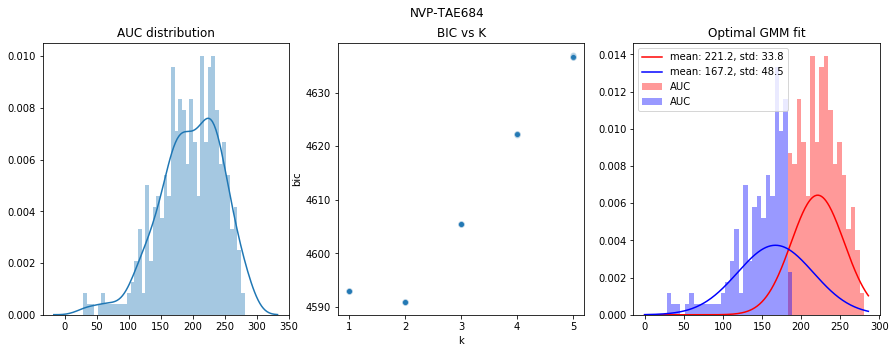

------------------------------------------------
Inhibitor:  Pazopanib (GW786034)
------------------------------------------------
Number of assays (aucs): 486
Optimal K: 2 [BIC=5087.4]
GMM fit:
	Mixture Weights: array([ 0.56246155,  0.43753845])
	Means: array([ 237.73450149,  188.62149669])
	Variances: array([  926.376757  ,  2163.34416825])
Class counts: ['class 0: 324', 'class 1: 162']


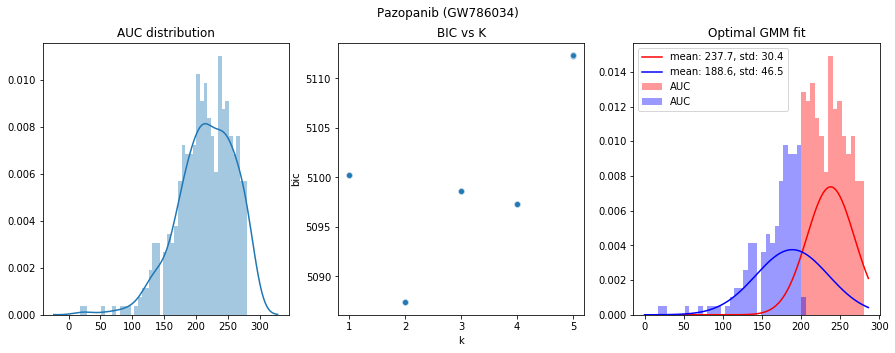

------------------------------------------------
Inhibitor:  PD173955
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 2 [BIC=4731.5]
GMM fit:
	Mixture Weights: array([ 0.51835518,  0.48164482])
	Means: array([ 237.10121396,  157.14386309])
	Variances: array([ 1138.17244864,  2048.8404387 ])
Class counts: ['class 0: 236', 'class 1: 198']


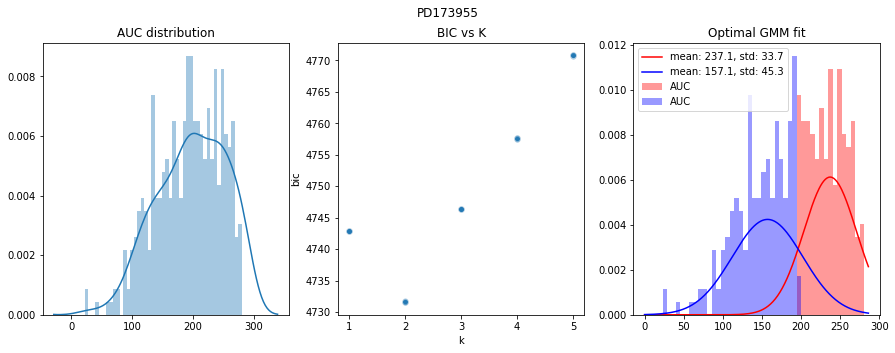

------------------------------------------------
Inhibitor:  Pelitinib (EKB-569)
------------------------------------------------
Number of assays (aucs): 431
Optimal K: 1 [BIC=4461.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 163.13544434])
	Variances: array([ 1783.6839003])
Class counts: ['class 0: 431']


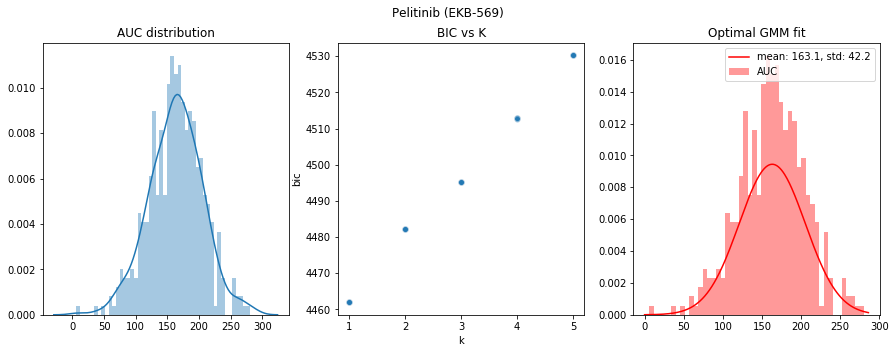

------------------------------------------------
Inhibitor:  PHA-665752
------------------------------------------------
Number of assays (aucs): 435
Optimal K: 2 [BIC=4450.1]
GMM fit:
	Mixture Weights: array([ 0.60141115,  0.39858885])
	Means: array([ 234.25505066,  193.57939407])
	Variances: array([  771.75489413,  1905.05584722])
Class counts: ['class 0: 322', 'class 1: 113']


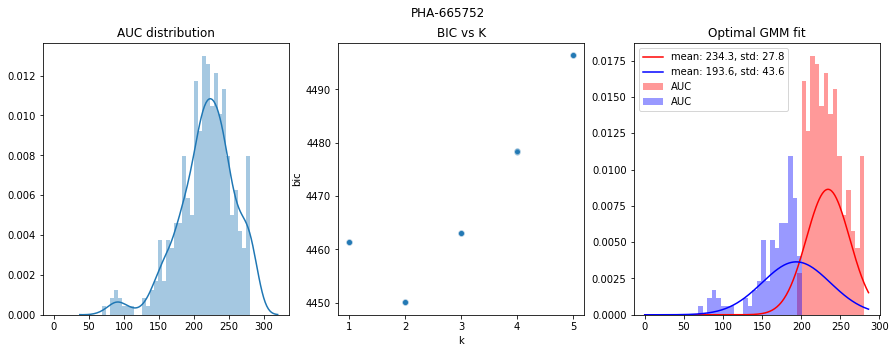

------------------------------------------------
Inhibitor:  PHT-427
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 4 [BIC=3020.3]
GMM fit:
	Mixture Weights: array([ 0.22465185,  0.28091945,  0.04595243,  0.44847627])
	Means: array([ 286.26924128,  242.46003986,  155.76442426,  276.77316975])
	Variances: array([  1.30092023e-03,   4.73604414e+02,   3.85258119e+03,
         6.42795184e+01])
Class counts: ['class 0: 95', 'class 1: 109', 'class 2: 14', 'class 3: 202']


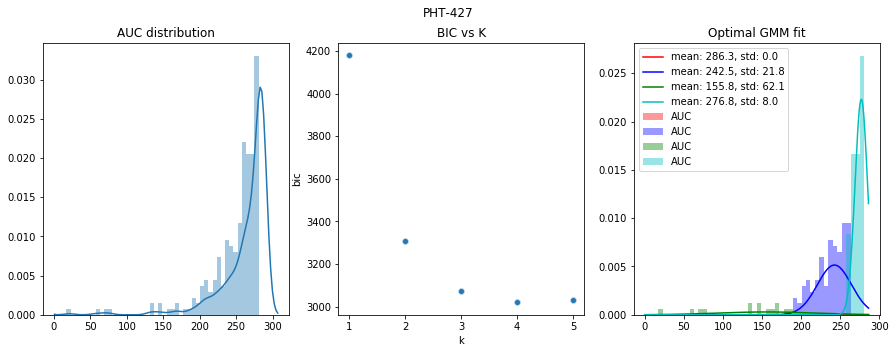

------------------------------------------------
Inhibitor:  PI-103
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4592.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 140.35699877])
	Variances: array([ 2356.66433103])
Class counts: ['class 0: 432']


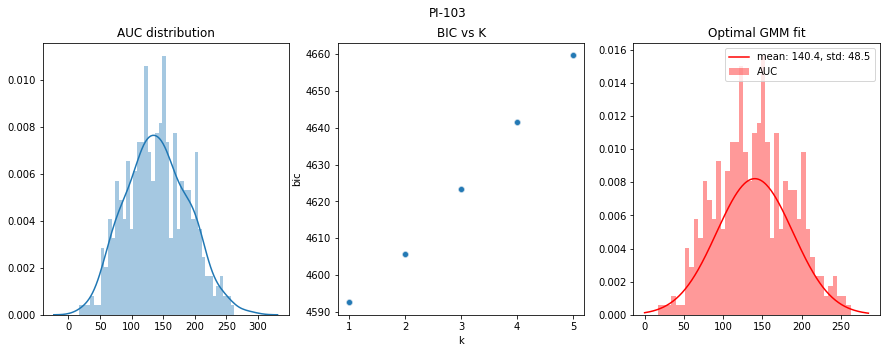

------------------------------------------------
Inhibitor:  Ponatinib (AP24534)
------------------------------------------------
Number of assays (aucs): 460
Optimal K: 2 [BIC=5002.3]
GMM fit:
	Mixture Weights: array([ 0.5210963,  0.4789037])
	Means: array([ 113.26869384,  193.48173313])
	Variances: array([ 1281.09410219,  1604.4604425 ])
Class counts: ['class 0: 248', 'class 1: 212']


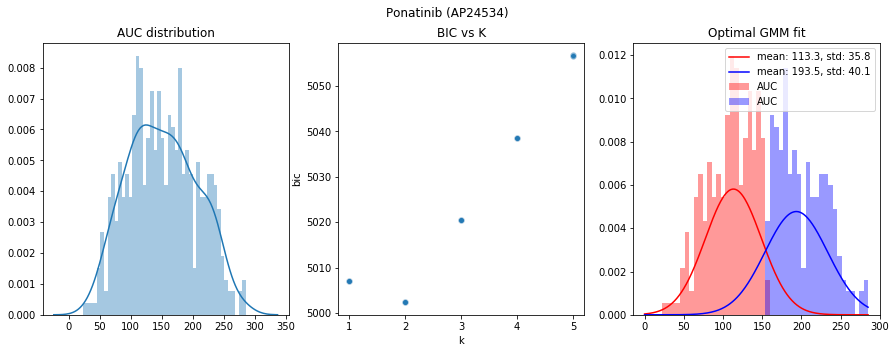

------------------------------------------------
Inhibitor:  PP242
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4575.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 139.92493152])
	Variances: array([ 2264.95055139])
Class counts: ['class 0: 432']


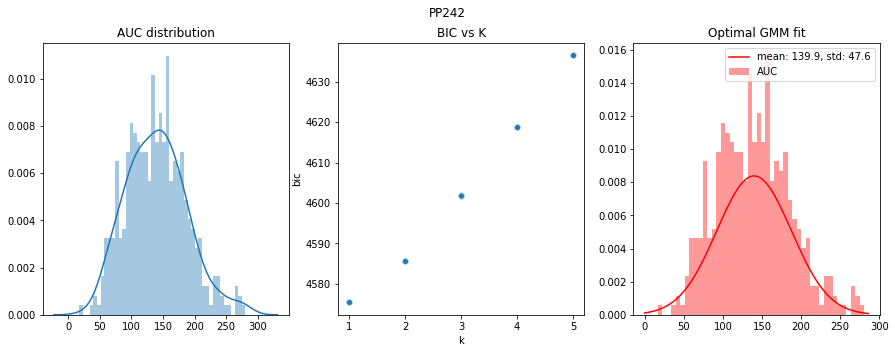

------------------------------------------------
Inhibitor:  PRT062607
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 1 [BIC=4441.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 193.47178256])
	Variances: array([ 1965.04677792])
Class counts: ['class 0: 425']


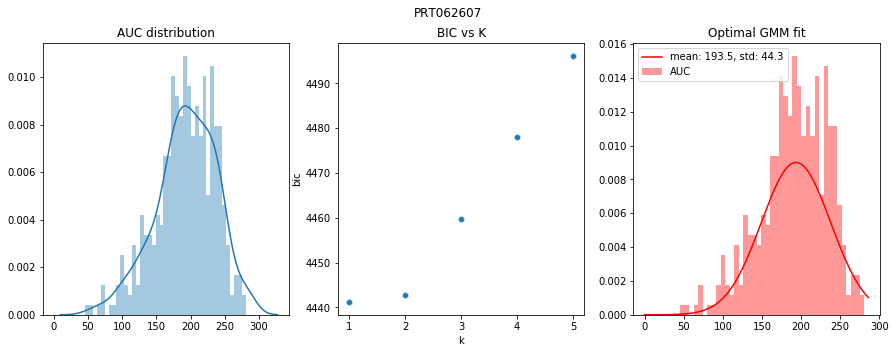

------------------------------------------------
Inhibitor:  Quizartinib (AC220)
------------------------------------------------
Number of assays (aucs): 450
Optimal K: 1 [BIC=4840.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 150.78371259])
	Variances: array([ 2673.21568139])
Class counts: ['class 0: 450']


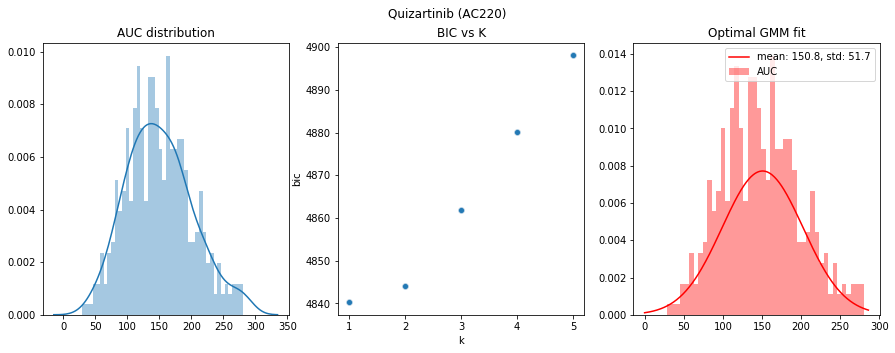

------------------------------------------------
Inhibitor:  RAF265 (CHIR-265)
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 1 [BIC=4478.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 165.39792308])
	Variances: array([ 2042.13577533])
Class counts: ['class 0: 427']


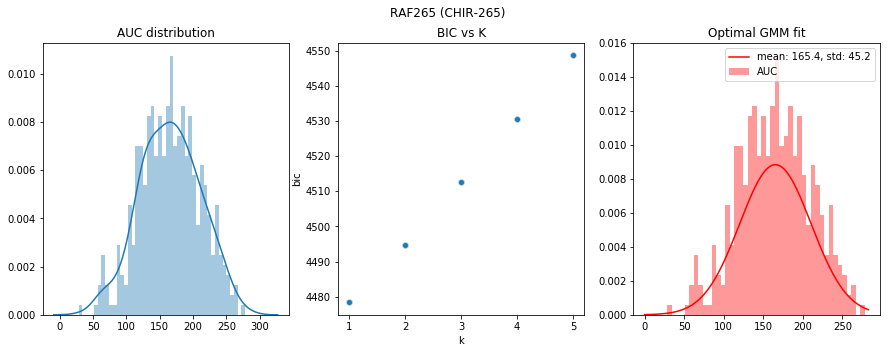

------------------------------------------------
Inhibitor:  Rapamycin
------------------------------------------------
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.98806926])
	Variances: array([ 3065.14456621])
Class counts: ['class 0: 478']


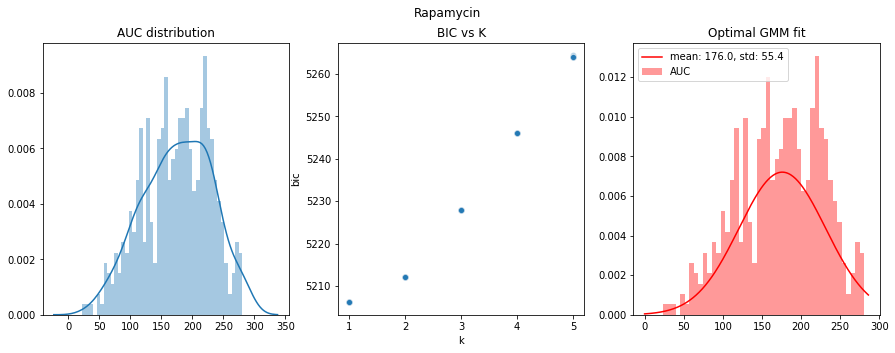

------------------------------------------------
Inhibitor:  Regorafenib (BAY 73-4506)
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 1 [BIC=4283.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 188.48395235])
	Variances: array([ 1422.67755284])
Class counts: ['class 0: 423']


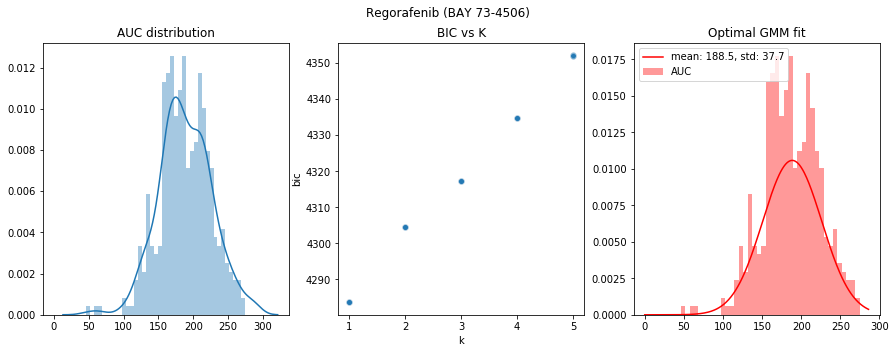

------------------------------------------------
Inhibitor:  Roscovitine (CYC-202)
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 5 [BIC=4061.8]
GMM fit:
	Mixture Weights: array([ 0.32043727,  0.09112542,  0.34134609,  0.01277575,  0.23431548])
	Means: array([ 261.51162005,  189.49961771,  279.33877999,   65.05391433,
        243.18779706])
	Variances: array([   93.40719841,  1047.78826706,    32.08005123,  1176.15506848,
         264.79389502])
Class counts: ['class 0: 153', 'class 1: 33', 'class 2: 159', 'class 3: 5', 'class 4: 88']


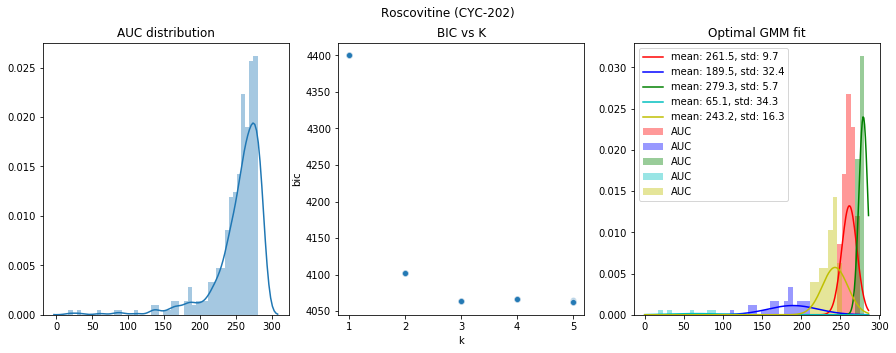

------------------------------------------------
Inhibitor:  Ruxolitinib (INCB018424)
------------------------------------------------
Number of assays (aucs): 475
Optimal K: 3 [BIC=4700.5]
GMM fit:
	Mixture Weights: array([ 0.44450288,  0.07944077,  0.47605634])
	Means: array([ 258.90372332,  174.7215596 ,  220.15762164])
	Variances: array([  339.18182279,  2042.03146949,   509.02343414])
Class counts: ['class 0: 222', 'class 1: 21', 'class 2: 232']


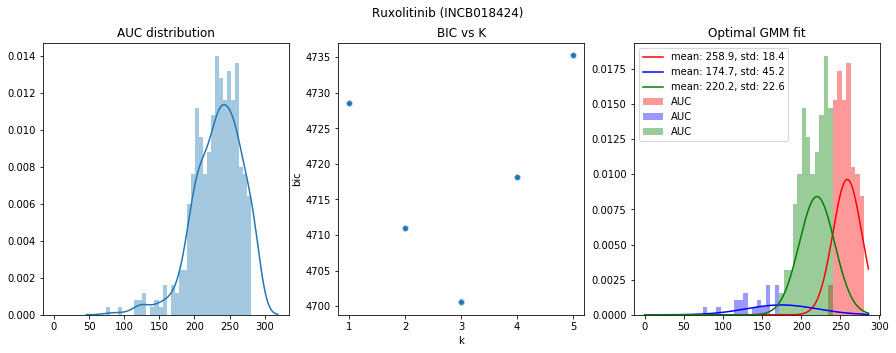

------------------------------------------------
Inhibitor:  S31-201
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 3 [BIC=4392.0]
GMM fit:
	Mixture Weights: array([ 0.4066592 ,  0.16071835,  0.43262245])
	Means: array([ 210.14513733,  155.34217268,  257.23533086])
	Variances: array([ 1007.85726447,  3142.785433  ,   339.71738007])
Class counts: ['class 0: 182', 'class 1: 39', 'class 2: 199']


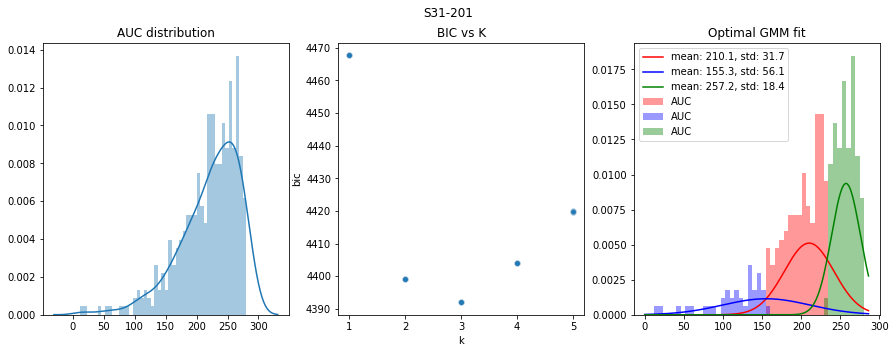

------------------------------------------------
Inhibitor:  Saracatinib (AZD0530)
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4366.8]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 213.96381985])
	Variances: array([ 1774.44701469])
Class counts: ['class 0: 422']


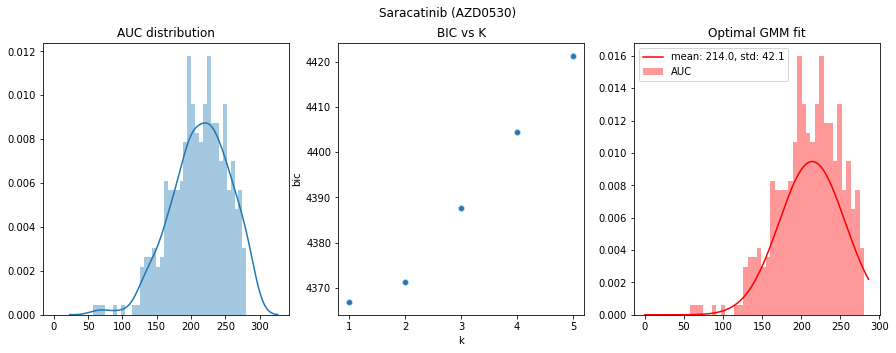

------------------------------------------------
Inhibitor:  SB-431542
------------------------------------------------
Number of assays (aucs): 437
Optimal K: 3 [BIC=4314.5]
GMM fit:
	Mixture Weights: array([ 0.50214701,  0.10343716,  0.39441584])
	Means: array([ 268.19406605,  153.92493116,  231.31765929])
	Variances: array([  164.59264623,  2619.55030895,   593.21279029])
Class counts: ['class 0: 243', 'class 1: 36', 'class 2: 158']


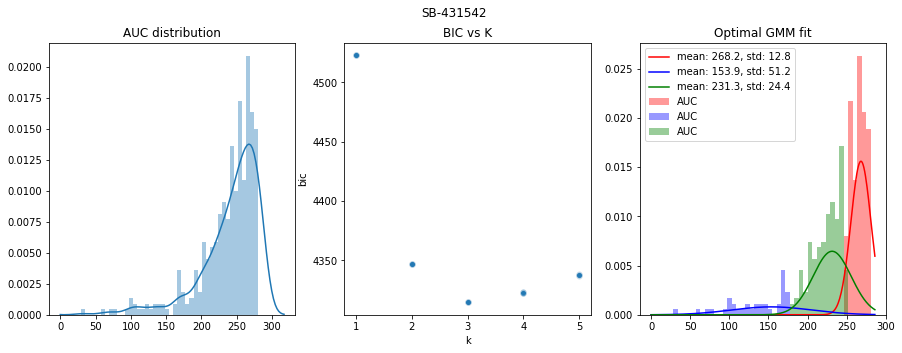

------------------------------------------------
Inhibitor:  Selumetinib (AZD6244)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 5 [BIC=4831.9]
GMM fit:
	Mixture Weights: array([ 0.12914925,  0.19407319,  0.29483783,  0.15333835,  0.22860138])
	Means: array([ 281.77366842,  151.06440004,  239.00738032,   95.63644597,
        175.89948627])
	Variances: array([   27.70942088,  1987.53537673,   557.58173208,  1286.40737068,
        1293.20958498])
Class counts: ['class 0: 61', 'class 1: 47', 'class 2: 141', 'class 3: 71', 'class 4: 113']


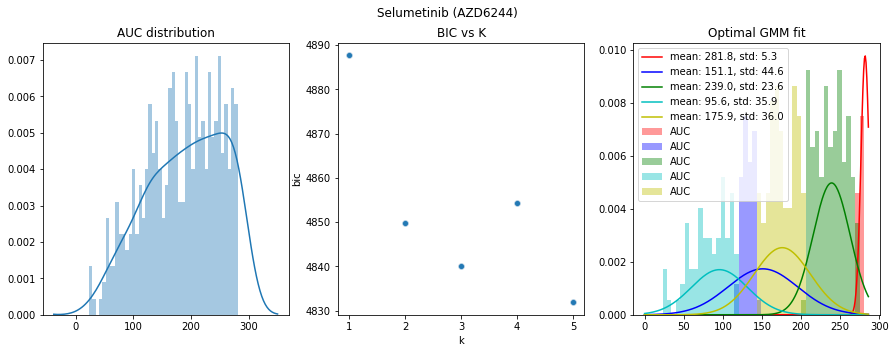

------------------------------------------------
Inhibitor:  SGX-523
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 4 [BIC=4097.7]
GMM fit:
	Mixture Weights: array([ 0.41246001,  0.02532665,  0.21454865,  0.34766469])
	Means: array([ 275.3699201 ,  104.54014774,  218.43878923,  250.78847195])
	Variances: array([   69.73373369,  1028.37441111,   678.82325862,   201.48519958])
Class counts: ['class 0: 197', 'class 1: 11', 'class 2: 73', 'class 3: 151']


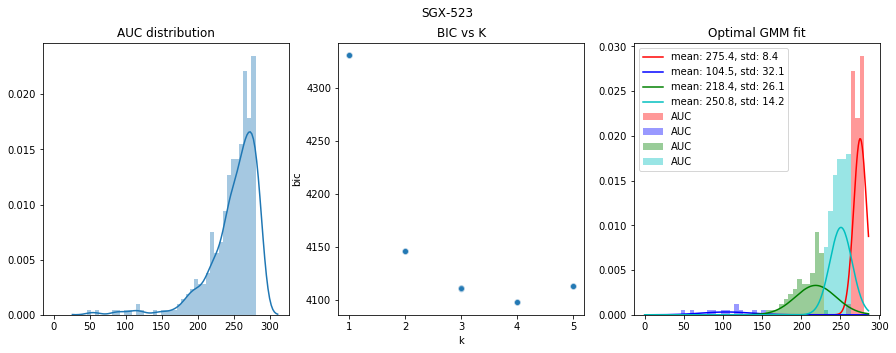

------------------------------------------------
Inhibitor:  SNS-032 (BMS-387032)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4374.0]
GMM fit:
	Mixture Weights: array([ 0.63533039,  0.36466961])
	Means: array([  88.47916265,  130.76451788])
	Variances: array([  536.55419975,  1915.14033014])
Class counts: ['class 0: 331', 'class 1: 105']


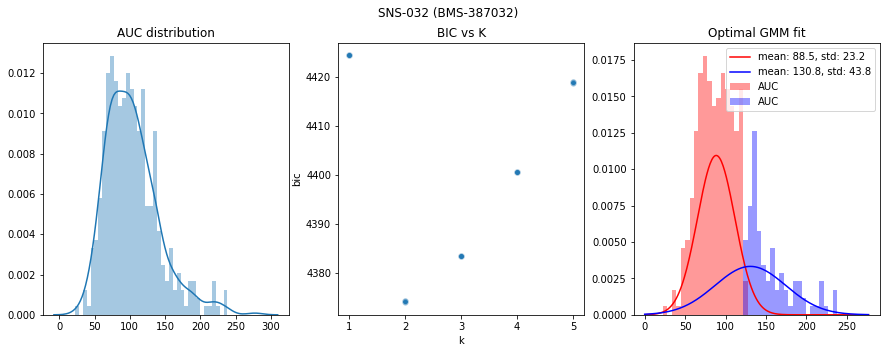

------------------------------------------------
Inhibitor:  Sorafenib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([ 0.57523925,  0.42476075])
	Means: array([ 220.70232329,  160.43097496])
	Variances: array([ 1141.4331894 ,  2577.01244736])
Class counts: ['class 0: 332', 'class 1: 173']


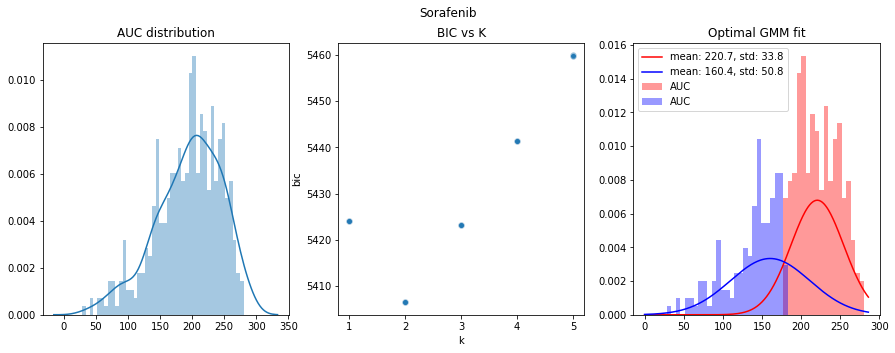

------------------------------------------------
Inhibitor:  STO609
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 4 [BIC=3948.7]
GMM fit:
	Mixture Weights: array([ 0.42245225,  0.28890567,  0.04916521,  0.23947687])
	Means: array([ 263.3165585 ,  235.74890513,  192.92558307,  281.66201871])
	Variances: array([   82.24762101,   374.673727  ,  1410.20555971,    14.75988029])
Class counts: ['class 0: 193', 'class 1: 115', 'class 2: 13', 'class 3: 115']


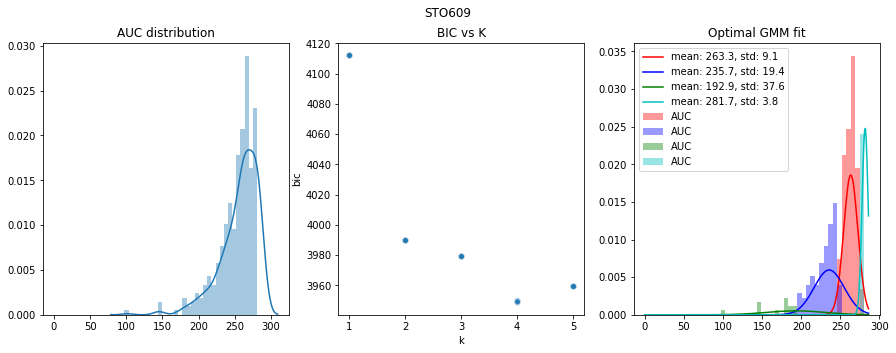

------------------------------------------------
Inhibitor:  SU11274
------------------------------------------------
Number of assays (aucs): 419
Optimal K: 1 [BIC=4235.8]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 218.06240027])
	Variances: array([ 1397.7889963])
Class counts: ['class 0: 419']


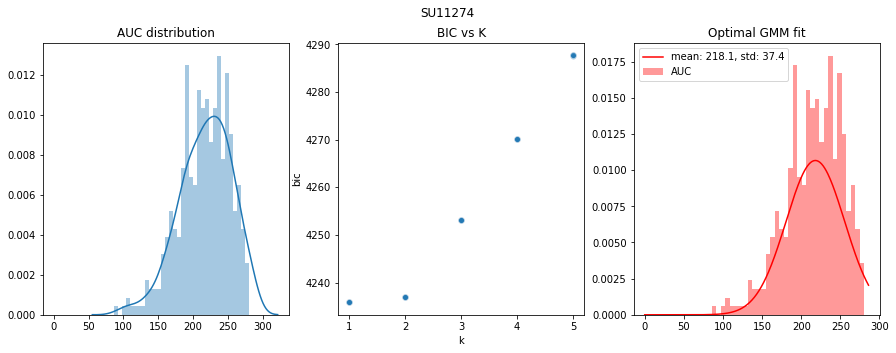

------------------------------------------------
Inhibitor:  Sunitinib
------------------------------------------------
Number of assays (aucs): 501
Optimal K: 2 [BIC=5264.8]
GMM fit:
	Mixture Weights: array([ 0.56875223,  0.43124777])
	Means: array([ 225.67490839,  170.94741204])
	Variances: array([  950.86260094,  2018.09015565])
Class counts: ['class 0: 322', 'class 1: 179']


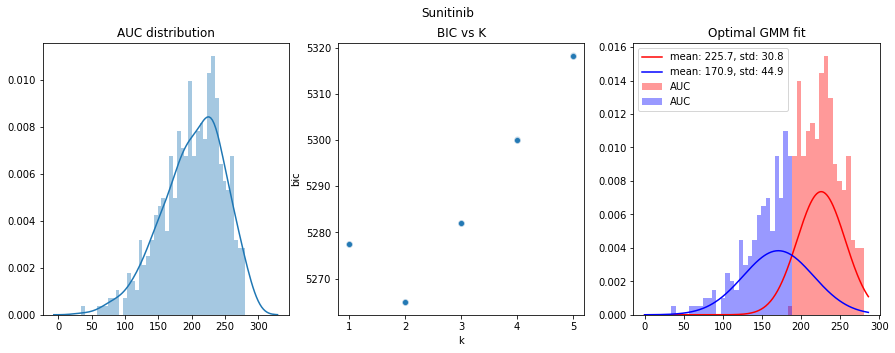

------------------------------------------------
Inhibitor:  TG100-115
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 3 [BIC=4175.4]
GMM fit:
	Mixture Weights: array([ 0.49170846,  0.06682865,  0.44146288])
	Means: array([ 228.43171408,  170.16320001,  263.28317478])
	Variances: array([  513.80887851,  2840.83713212,   222.1720587 ])
Class counts: ['class 0: 202', 'class 1: 16', 'class 2: 211']


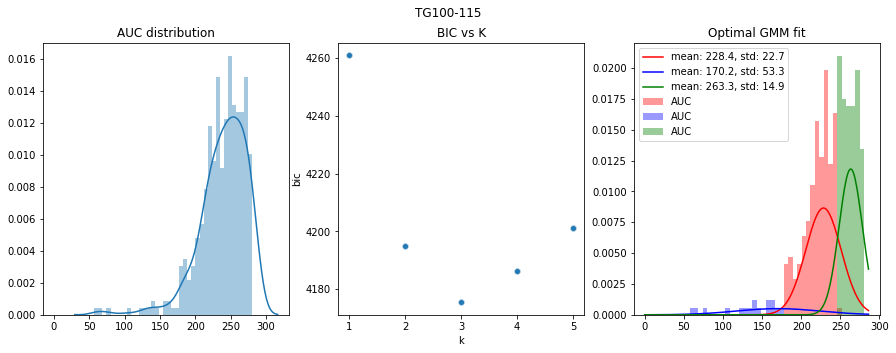

------------------------------------------------
Inhibitor:  Tivozanib (AV-951)
------------------------------------------------
Number of assays (aucs): 421
Optimal K: 2 [BIC=4648.1]
GMM fit:
	Mixture Weights: array([ 0.50471566,  0.49528434])
	Means: array([ 124.67058888,  215.39570995])
	Variances: array([ 1527.39653298,  1553.32591854])
Class counts: ['class 0: 213', 'class 1: 208']


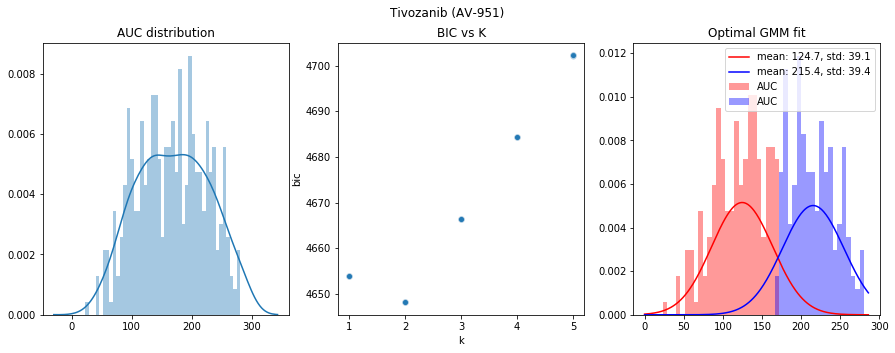

------------------------------------------------
Inhibitor:  Tofacitinib (CP-690550)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 2 [BIC=4402.2]
GMM fit:
	Mixture Weights: array([ 0.60399973,  0.39600027])
	Means: array([ 232.02455827,  193.93273443])
	Variances: array([  661.97465245,  1981.27750847])
Class counts: ['class 0: 318', 'class 1: 116']


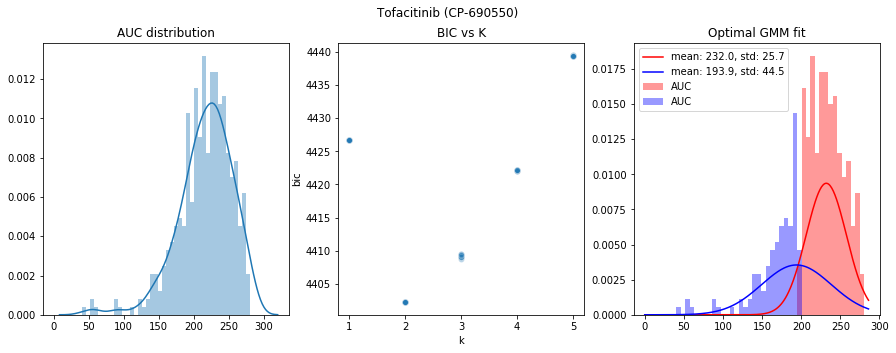

------------------------------------------------
Inhibitor:  Tozasertib (VX-680)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4440.2]
GMM fit:
	Mixture Weights: array([ 0.66291631,  0.33708369])
	Means: array([ 227.08966462,  184.24468239])
	Variances: array([  718.34101867,  2144.77726346])
Class counts: ['class 0: 352', 'class 1: 84']


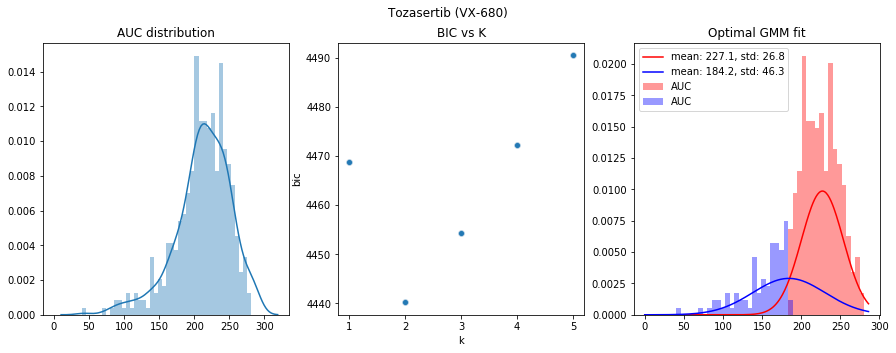

------------------------------------------------
Inhibitor:  Trametinib (GSK1120212)
------------------------------------------------
Number of assays (aucs): 454
Optimal K: 2 [BIC=5063.9]
GMM fit:
	Mixture Weights: array([ 0.46362194,  0.53637806])
	Means: array([ 184.25571516,   86.55306617])
	Variances: array([ 2471.94396084,  1299.10847577])
Class counts: ['class 0: 203', 'class 1: 251']


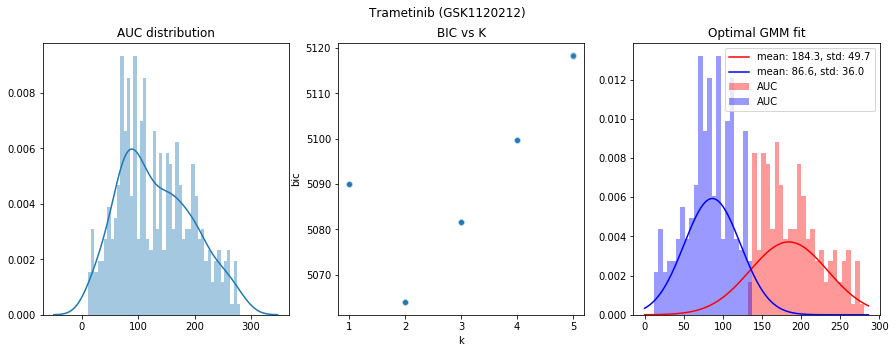

------------------------------------------------
Inhibitor:  Vandetanib (ZD6474)
------------------------------------------------
Number of assays (aucs): 491
Optimal K: 5 [BIC=5054.9]
GMM fit:
	Mixture Weights: array([ 0.23883119,  0.32140919,  0.17817911,  0.0189327 ,  0.2426478 ])
	Means: array([ 215.95729148,  235.15773733,  183.15361349,   66.91483561,
        273.24601233])
	Variances: array([  812.69834388,   296.25930067,  1084.73172519,  1224.04932197,
         112.54173043])
Class counts: ['class 0: 68', 'class 1: 207', 'class 2: 75', 'class 3: 9', 'class 4: 132']


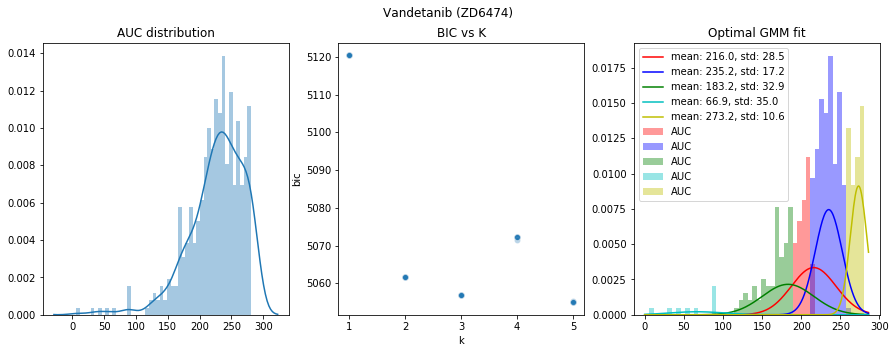

------------------------------------------------
Inhibitor:  Vargetef
------------------------------------------------
Number of assays (aucs): 428
Optimal K: 1 [BIC=4615.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 182.10557169])
	Variances: array([ 2748.30058672])
Class counts: ['class 0: 428']


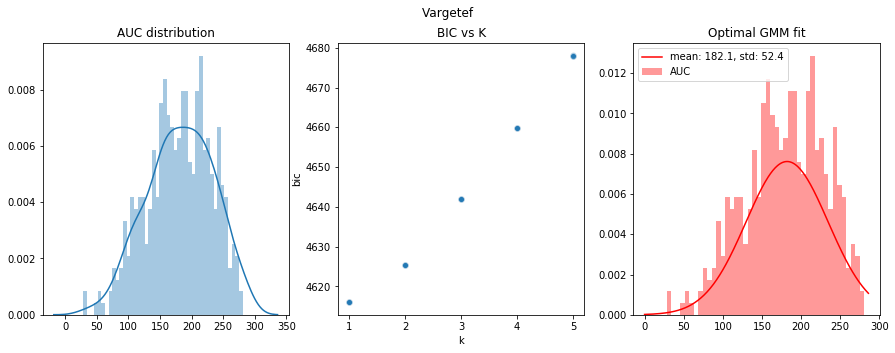

------------------------------------------------
Inhibitor:  Vatalanib (PTK787)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 2 [BIC=4367.9]
GMM fit:
	Mixture Weights: array([ 0.72056929,  0.27943071])
	Means: array([ 232.81379574,  186.45016304])
	Variances: array([  625.62022354,  2804.42609938])
Class counts: ['class 0: 363', 'class 1: 69']


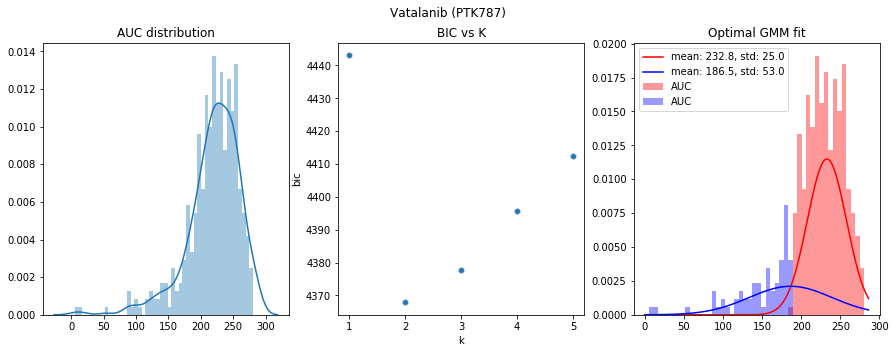

------------------------------------------------
Inhibitor:  Vismodegib (GDC-0449)
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 4 [BIC=2723.7]
GMM fit:
	Mixture Weights: array([ 0.41807906,  0.18161235,  0.36307667,  0.03723192])
	Means: array([ 286.10392251,  251.01106337,  277.91069045,  115.23774358])
	Variances: array([  6.45074411e-02,   2.63734169e+02,   3.18750336e+01,
         3.77843623e+03])
Class counts: ['class 0: 186', 'class 1: 69', 'class 2: 157', 'class 3: 15']


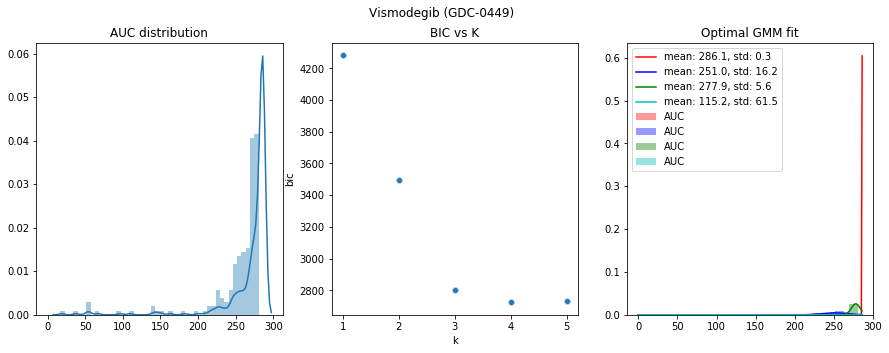

------------------------------------------------
Inhibitor:  VX-745
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4599.1]
GMM fit:
	Mixture Weights: array([ 0.38003257,  0.61996743])
	Means: array([ 159.43861583,  217.73189101])
	Variances: array([ 2245.24318799,   972.28550644])
Class counts: ['class 0: 122', 'class 1: 314']


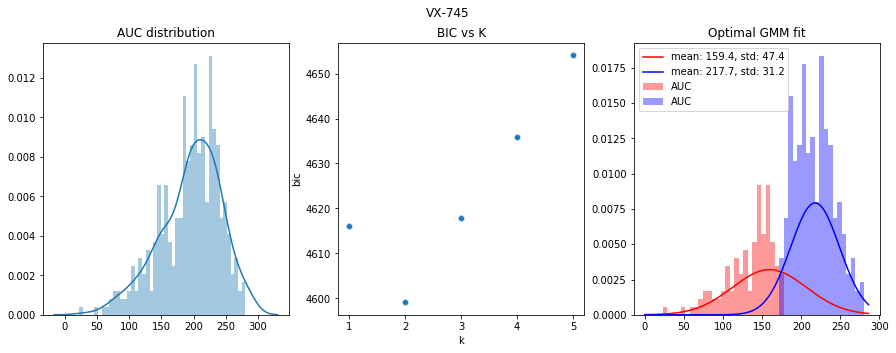

------------------------------------------------
Inhibitor:  XAV-939
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 5 [BIC=4216.0]
GMM fit:
	Mixture Weights: array([ 0.22801404,  0.28391022,  0.17579043,  0.2776032 ,  0.03468212])
	Means: array([ 223.64862867,  280.62509328,  189.72065053,  259.33295564,
        138.2949221 ])
	Variances: array([  477.9013666 ,    27.61396943,  1186.28896256,   152.13634229,
        3551.45313657])
Class counts: ['class 0: 102', 'class 1: 134', 'class 2: 66', 'class 3: 116', 'class 4: 4']


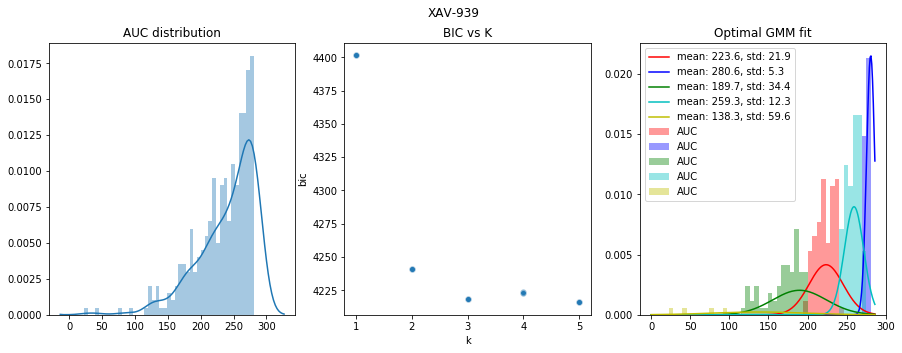

------------------------------------------------
Inhibitor:  YM-155
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 4 [BIC=4293.3]
GMM fit:
	Mixture Weights: array([ 0.41133395,  0.24887023,  0.04197242,  0.29782339])
	Means: array([ 248.08561307,  279.42325154,  175.08078398,  212.2240844 ])
	Variances: array([  287.4991658 ,    36.56865149,  2604.53227968,   717.58205777])
Class counts: ['class 0: 195', 'class 1: 120', 'class 2: 6', 'class 3: 117']


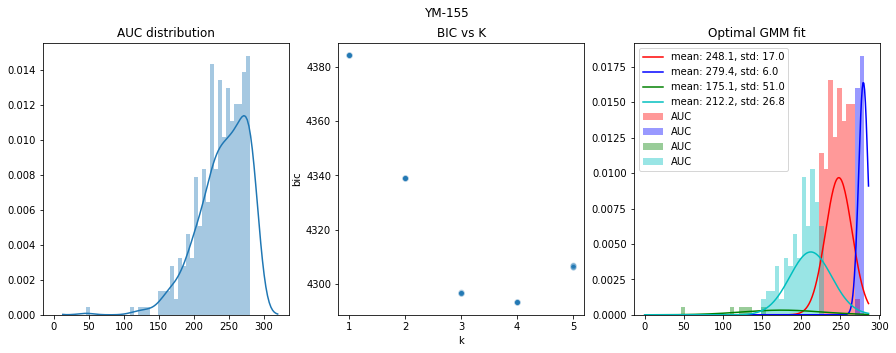

In [97]:
for inhib in aml_aucs.inhibitor.unique(): 
    inhib_dat = aml_aucs[aml_aucs.inhibitor == inhib]
    if inhib_dat.shape[0] > 400: 
        print('------------------------------------------------')
        print('Inhibitor:  %s' %inhib)
        print('------------------------------------------------')
        AUCS =  inhib_dat.auc.values.reshape(-1,1)
        test_multimodal_fits(AUCS, ntests=10, kmax=6, plot=True)
    

In [98]:
okay_data = ['YM-155', 'Vandetanib (ZD6474)', 'Trametinib (GSK1120212)', 'Sunitinib','Sorafenib', 'Selumetinib (AZD6244)', 'Nilotinib', 'JAK Inhibitor I', 'Pazopanib (GW786034)', 'Elesclomol', 'Dasatinib']

dat = aml_aucs[aml_aucs.inhibitor.isin(okay_data)]
dat.to_csv('./../data/beatAML_AUCs_subset.csv')
